In [6]:
# eda_btc_close.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Cargar datos
btc = pd.read_csv("btc_1d_data_2018_to_2025.csv")

print("Shape:", btc.shape)
print(btc.head())


Shape: (2594, 12)
    Open time      Open      High       Low     Close        Volume  \
0  2018-01-01  13715.65  13818.55  12750.00  13380.00   8609.915844   
1  2018-01-02  13382.16  15473.49  12890.02  14675.11  20078.092111   
2  2018-01-03  14690.00  15307.56  14150.00  14919.51  15905.667639   
3  2018-01-04  14919.51  15280.00  13918.04  15059.54  21329.649574   
4  2018-01-05  15059.56  17176.24  14600.00  16960.39  23251.491125   

                Close time  Quote asset volume  Number of trades  \
0  2018-01-01 23:59:59.999        1.147997e+08            105595   
1  2018-01-02 23:59:59.999        2.797171e+08            177728   
2  2018-01-03 23:59:59.999        2.361169e+08            162787   
3  2018-01-04 23:59:59.999        3.127816e+08            170310   
4  2018-01-05 23:59:59.999        3.693220e+08            192969   

   Taker buy base asset volume  Taker buy quote asset volume  Ignore  
0                  3961.938946                  5.280975e+07       0  
1   

In [138]:
# Bitcoin Price Prediction Pipeline - EJECUCIÓN COMPLETA
# Predicción del precio de cierre diario de Bitcoin usando MLP y análisis de residuos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías para modeling y evaluación
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Librerías para análisis temporal
from statsmodels.tsa.stattools import acf
from scipy import stats

# Configuración de visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("🚀 INICIANDO ANÁLISIS COMPLETO DE PREDICCIÓN DE BITCOIN")
print("=" * 60)

# =============================================================================
# 1. CARGA Y PREPROCESAMIENTO DE DATOS
# =============================================================================

print("\n1. CARGA Y PREPROCESAMIENTO DE DATOS")
print("-" * 40)

# Cargar datos reales del CSV
data = pd.read_csv('btc_1d_data_2018_to_2025.csv')
data = data[['Open time', 'Close']].copy()
data = data.rename(columns={'Open time': 'Date'})

print(f"✅ Datos creados: {len(data)} observaciones")
print(f"📅 Rango temporal: {data['Date'].min()} a {data['Date'].max()}")
print(f"💰 Rango de precios: ${data['Close'].min():.2f} - ${data['Close'].max():.2f}")

# Calcular retornos logarítmicos
data['returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Crear grupos temporales para validación cruzada
data['time_group'] = (data.index // 30).astype(int)

# Eliminar NaN solo para el cálculo de estadísticas
returns_clean = data['returns'].dropna()

print(f"📊 Retornos calculados. Volatilidad anualizada: {returns_clean.std() * np.sqrt(252):.4f}")

# =============================================================================
# 2. ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# =============================================================================

print("\n2. ANÁLISIS EXPLORATORIO DE DATOS")
print("-" * 40)

# Estadísticas descriptivas
print("📈 ESTADÍSTICAS DESCRIPTIVAS DEL PRECIO:")
print(data['Close'].describe())

print("\n📉 ESTADÍSTICAS DESCRIPTIVAS DE LOS RETORNOS:")
returns_clean = data['returns'].dropna()
print(returns_clean.describe())
print(f"Sesgo: {stats.skew(returns_clean):.4f}")
print(f"Curtosis: {stats.kurtosis(returns_clean):.4f}")

# Visualizaciones EDA
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis Exploratorio de Datos - Bitcoin', fontsize=16, fontweight='bold')

# Serie de precios
axes[0,0].plot(data['Date'], data['Close'], color='#2E86C1', linewidth=1.5)
axes[0,0].set_title('📈 Serie Temporal de Precios BTC', fontweight='bold')
axes[0,0].set_xlabel('Fecha')
axes[0,0].set_ylabel('Precio (USD)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# Retornos diarios
returns_clean = data['returns'].dropna()
dates_returns = data['Date'].iloc[1:1+len(returns_clean)]  # Fechas correspondientes a los retornos
axes[0,1].plot(dates_returns, returns_clean, color='#E74C3C', alpha=0.7, linewidth=0.8)
axes[0,1].set_title('📊 Retornos Logarítmicos Diarios', fontweight='bold')
axes[0,1].set_xlabel('Fecha')
axes[0,1].set_ylabel('Retorno')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)

# Histograma de retornos
axes[1,0].hist(returns_clean, bins=50, alpha=0.7, color='#28B463', density=True, edgecolor='black')
axes[1,0].axvline(returns_clean.mean(), color='red', linestyle='--', label=f'Media: {returns_clean.mean():.4f}')
axes[1,0].axvline(returns_clean.median(), color='blue', linestyle='--', label=f'Mediana: {returns_clean.median():.4f}')
axes[1,0].set_title('📊 Distribución de Retornos', fontweight='bold')
axes[1,0].set_xlabel('Retorno')
axes[1,0].set_ylabel('Densidad')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Autocorrelación de retornos
lags = range(1, 21)
acf_returns = acf(returns_clean, nlags=20, fft=True)[1:]
axes[1,1].bar(lags, acf_returns, alpha=0.7, color='#8E44AD')
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
confidence_interval = 1.96/np.sqrt(len(returns_clean))
axes[1,1].axhline(y=confidence_interval, color='red', linestyle='--', alpha=0.7)
axes[1,1].axhline(y=-confidence_interval, color='red', linestyle='--', alpha=0.7)
axes[1,1].set_title('🔄 Autocorrelación de Retornos', fontweight='bold')
axes[1,1].set_xlabel('Lag')
axes[1,1].set_ylabel('ACF')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 3. FUNCIÓN PARA CREAR FEATURES Y TARGETS
# =============================================================================

def create_features_targets(data, lag_size, prediction_horizon=7):
    """Crear features (lags) y targets (multi-step)"""
    data_work = data.copy()
    
    # Crear lags del precio
    feature_cols = []
    for i in range(1, lag_size + 1):
        col_name = f'close_lag_{i}'
        data_work[col_name] = data_work['Close'].shift(i)
        feature_cols.append(col_name)
    
    # Crear targets multi-step
    target_cols = []
    for h in range(1, prediction_horizon + 1):
        col_name = f'close_lead_{h}'
        data_work[col_name] = data_work['Close'].shift(-h)
        target_cols.append(col_name)
    
    # Eliminar NaN
    data_work = data_work.dropna().reset_index(drop=True)
    
    X = data_work[feature_cols].values
    y = data_work[target_cols].values
    dates = data_work['Date'].values
    time_groups = data_work['time_group'].values
    
    return X, y, dates, time_groups

# =============================================================================
# 4. FUNCIÓN PARA VALIDACIÓN CRUZADA TEMPORAL
# =============================================================================

def create_temporal_splits(X, y, dates, time_groups, n_splits=5):
    """Crear splits temporales usando GroupKFold"""
    gkf = GroupKFold(n_splits=n_splits)
    splits = []
    
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, time_groups)):
        # Dividir train en train/val (80/20)
        n_train = int(0.8 * len(train_idx))
        actual_train_idx = train_idx[:n_train]
        val_idx = train_idx[n_train:]
        
        splits.append({
            'fold': fold + 1,
            'train_idx': actual_train_idx,
            'val_idx': val_idx,
            'test_idx': test_idx
        })
    
    return splits

# =============================================================================
# 5. FUNCIÓN PARA TEST DE INDEPENDENCIA (BDS SIMPLIFICADO)
# =============================================================================

def independence_test(residuals):
    """Test de independencia simplificado basado en autocorrelación"""
    if len(residuals) < 10:
        return 0.5
    
    # Normalizar residuos
    residuals_norm = (residuals - np.mean(residuals)) / np.std(residuals)
    
    # Calcular autocorrelación de primer orden
    if len(residuals_norm) > 1:
        autocorr = np.corrcoef(residuals_norm[:-1], residuals_norm[1:])[0, 1]
    else:
        autocorr = 0
    
    # Test estadístico
    n = len(residuals_norm)
    test_stat = abs(autocorr) * np.sqrt(n)
    pvalue = 2 * (1 - stats.norm.cdf(test_stat))
    
    return max(min(pvalue, 1.0), 0.0)

# =============================================================================
# 6. ENTRENAMIENTO Y EVALUACIÓN PARA CADA LAG SIZE
# =============================================================================

print("\n3. ENTRENAMIENTO Y EVALUACIÓN DE MODELOS")
print("-" * 40)

lag_sizes = [7, 14, 21, 28]
prediction_horizon = 7
all_results = {}

for lag_size in lag_sizes:
    print(f"\n🔄 PROCESANDO LAG SIZE: {lag_size}")
    print(f"{'='*30}")
    
    # Crear features y targets
    X, y, dates, time_groups = create_features_targets(data, lag_size, prediction_horizon)
    print(f"✅ Features: {X.shape}, Targets: {y.shape}")
    
    # Crear splits temporales
    splits = create_temporal_splits(X, y, dates, time_groups)
    print(f"✅ Creados {len(splits)} folds temporales")
    
    fold_results = []
    fold_predictions = {}
    
    # Entrenar para cada fold
    for split in splits:
        fold = split['fold']
        print(f"  📊 Fold {fold}...", end=" ")
        
        # Extraer datos
        train_idx, val_idx, test_idx = split['train_idx'], split['val_idx'], split['test_idx']
        X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
        y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]
        
        # Escalar
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        # Crear y entrenar modelo MLP
        model = MLPRegressor(
            hidden_layer_sizes=(100, 50),
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.1,
            random_state=42,
            alpha=0.001
        )
        
        model.fit(X_train_scaled, y_train)
        
        # Predicciones
        y_test_pred = model.predict(X_test_scaled)
        
        # Guardar predicciones para visualización
        fold_predictions[fold] = {
            'test_actual': y_test,
            'test_pred': y_test_pred,
            'test_dates': dates[test_idx]
        }
        
        # Calcular métricas por horizonte
        fold_metrics = {}
        for h in range(prediction_horizon):
            y_true_h = y_test[:, h]
            y_pred_h = y_test_pred[:, h]
            
            fold_metrics[f'h{h+1}'] = {
                'MAPE': mean_absolute_percentage_error(y_true_h, y_pred_h) * 100,
                'MAE': mean_absolute_error(y_true_h, y_pred_h),
                'RMSE': np.sqrt(mean_squared_error(y_true_h, y_pred_h)),
                'MSE': mean_squared_error(y_true_h, y_pred_h)
            }
        
        # Test BDS para residuos del horizonte 1
        residuals_h1 = y_test[:, 0] - y_test_pred[:, 0]
        bds_pvalue = independence_test(residuals_h1)
        fold_metrics['BDS_pvalue_h1'] = bds_pvalue
        
        fold_results.append({
            'fold': fold,
            'metrics': fold_metrics
        })
        
        # Calcular RMSE promedio para este fold
        rmse_avg = np.mean([fold_metrics[f'h{h+1}']['RMSE'] for h in range(prediction_horizon)])
        print(f"RMSE={rmse_avg:.2f}, BDS p-value={bds_pvalue:.4f}")
    
    # Guardar resultados
    all_results[lag_size] = {
        'fold_results': fold_results,
        'fold_predictions': fold_predictions
    }

# =============================================================================
# 7. CREAR TABLAS DE RESULTADOS
# =============================================================================

print("\n4. TABLAS DE RESULTADOS")
print("-" * 40)

for lag_size in lag_sizes:
    print(f"\n📊 RESULTADOS PARA LAG {lag_size}")
    print("=" * 50)
    
    fold_results = all_results[lag_size]['fold_results']
    
    # Crear tabla de resultados
    table_data = []
    
    for fold_result in fold_results:
        fold = fold_result['fold']
        metrics = fold_result['metrics']
        
        row = [f"Fold {fold}"]
        
        # RMSE por horizonte
        for h in range(prediction_horizon):
            row.append(f"{metrics[f'h{h+1}']['RMSE']:.4f}")
        
        # RMSE promedio
        rmse_avg = np.mean([metrics[f'h{h+1}']['RMSE'] for h in range(prediction_horizon)])
        row.append(f"{rmse_avg:.4f}")
        
        # MAPE promedio
        mape_avg = np.mean([metrics[f'h{h+1}']['MAPE'] for h in range(prediction_horizon)])
        row.append(f"{mape_avg:.2f}%")
        
        # BDS p-value
        row.append(f"{metrics['BDS_pvalue_h1']:.4f}")
        
        table_data.append(row)
    
    # Calcular promedios
    all_rmse_h = {f'h{h+1}': [] for h in range(prediction_horizon)}
    all_mape = []
    all_bds = []
    
    for fold_result in fold_results:
        metrics = fold_result['metrics']
        for h in range(prediction_horizon):
            all_rmse_h[f'h{h+1}'].append(metrics[f'h{h+1}']['RMSE'])
        
        mape_avg = np.mean([metrics[f'h{h+1}']['MAPE'] for h in range(prediction_horizon)])
        all_mape.append(mape_avg)
        all_bds.append(metrics['BDS_pvalue_h1'])
    
    # Fila de promedios
    mean_row = ["Mean ± Std"]
    for h in range(prediction_horizon):
        values = all_rmse_h[f'h{h+1}']
        mean_row.append(f"{np.mean(values):.4f} ± {np.std(values):.4f}")
    
    mean_row.append(f"{np.mean([np.mean(list(all_rmse_h.values()))]) :.4f} ± {np.std([np.mean(list(all_rmse_h.values()))]):.4f}")
    mean_row.append(f"{np.mean(all_mape):.2f}% ± {np.std(all_mape):.2f}%")
    mean_row.append(f"{np.mean(all_bds):.4f} ± {np.std(all_bds):.4f}")
    
    table_data.append(mean_row)
    
    # Mostrar tabla
    headers = ["Fold"] + [f"RMSE_h{h+1}" for h in range(prediction_horizon)] + ["RMSE_avg", "MAPE_avg", "BDS_p_h1"]
    
    print(f"{'':>12} ", end="")
    for header in headers[1:]:
        print(f"{header:>12} ", end="")
    print()
    
    print("-" * (13 * len(headers)))
    
    for row in table_data:
        for i, cell in enumerate(row):
            if i == 0:
                print(f"{cell:>12} ", end="")
            else:
                print(f"{cell:>12} ", end="")
        print()
    
    print()

# =============================================================================
# 8. VISUALIZACIONES
# =============================================================================

print("\n5. VISUALIZACIONES")
print("-" * 40)

# Gráfico comparativo de RMSE por lag size
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Resultados de Predicción por Tamaño de Lag', fontsize=16, fontweight='bold')

lag_rmse_means = []
lag_rmse_stds = []

for i, lag_size in enumerate(lag_sizes):
    ax = axes[i//2, i%2]
    
    fold_results = all_results[lag_size]['fold_results']
    fold_predictions = all_results[lag_size]['fold_predictions']
    
    # Calcular RMSE por fold
    fold_rmse = []
    for fold_result in fold_results:
        rmse_avg = np.mean([fold_result['metrics'][f'h{h+1}']['RMSE'] for h in range(prediction_horizon)])
        fold_rmse.append(rmse_avg)
    
    lag_rmse_means.append(np.mean(fold_rmse))
    lag_rmse_stds.append(np.std(fold_rmse))
    
    # Gráfico de barras por fold
    fold_numbers = [f"Fold {j+1}" for j in range(len(fold_rmse))]
    bars = ax.bar(fold_numbers, fold_rmse, alpha=0.7, color=f'C{i}')
    ax.axhline(y=np.mean(fold_rmse), color='red', linestyle='--', alpha=0.8, 
               label=f'Promedio: {np.mean(fold_rmse):.2f}')
    
    ax.set_title(f'LAG {lag_size} - RMSE por Fold', fontweight='bold')
    ax.set_ylabel('RMSE')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Añadir valores sobre las barras
    for bar, value in zip(bars, fold_rmse):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Gráfico de comparación entre lag sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RMSE promedio por lag size
ax1.bar(lag_sizes, lag_rmse_means, yerr=lag_rmse_stds, alpha=0.7, 
        color=['#3498DB', '#E74C3C', '#2ECC71', '#F39C12'], capsize=5)
ax1.set_title('RMSE Promedio por Tamaño de Lag', fontweight='bold')
ax1.set_xlabel('Tamaño de Lag')
ax1.set_ylabel('RMSE')
ax1.grid(True, alpha=0.3)

# Añadir valores sobre las barras
for i, (mean_val, std_val) in enumerate(zip(lag_rmse_means, lag_rmse_stds)):
    ax1.text(lag_sizes[i], mean_val + std_val + 10, f'{mean_val:.1f}±{std_val:.1f}',
             ha='center', va='bottom', fontweight='bold')

# RMSE por horizonte para el mejor lag
best_lag = lag_sizes[np.argmin(lag_rmse_means)]
fold_results = all_results[best_lag]['fold_results']

horizons = list(range(1, prediction_horizon + 1))
horizon_rmse = []

for h in range(prediction_horizon):
    h_rmse = [fold_result['metrics'][f'h{h+1}']['RMSE'] for fold_result in fold_results]
    horizon_rmse.append(np.mean(h_rmse))

ax2.plot(horizons, horizon_rmse, marker='o', linewidth=2, markersize=8, color='#E74C3C')
ax2.set_title(f'RMSE por Horizonte - Mejor Lag ({best_lag})', fontweight='bold')
ax2.set_xlabel('Horizonte de Predicción')
ax2.set_ylabel('RMSE')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(horizons)

plt.tight_layout()
plt.show()

# =============================================================================
# 9. TABLA COMPARATIVA FINAL
# =============================================================================

print("\n6. TABLA COMPARATIVA FINAL")
print("-" * 40)

print("🏆 RESUMEN COMPARATIVO POR TAMAÑO DE LAG")
print("=" * 60)

comparison_data = []
for lag_size in lag_sizes:
    fold_results = all_results[lag_size]['fold_results']
    
    # Calcular métricas agregadas
    all_rmse = []
    all_mape = []
    all_mae = []
    all_bds = []
    
    for fold_result in fold_results:
        metrics = fold_result['metrics']
        
        # Promediar sobre horizontes
        fold_rmse = np.mean([metrics[f'h{h+1}']['RMSE'] for h in range(prediction_horizon)])
        fold_mape = np.mean([metrics[f'h{h+1}']['MAPE'] for h in range(prediction_horizon)])
        fold_mae = np.mean([metrics[f'h{h+1}']['MAE'] for h in range(prediction_horizon)])
        
        all_rmse.append(fold_rmse)
        all_mape.append(fold_mape)
        all_mae.append(fold_mae)
        all_bds.append(metrics['BDS_pvalue_h1'])
    
    comparison_data.append({
        'Lag_Size': lag_size,
        'RMSE_mean': np.mean(all_rmse),
        'RMSE_std': np.std(all_rmse),
        'MAPE_mean': np.mean(all_mape),
        'MAPE_std': np.std(all_mape),
        'MAE_mean': np.mean(all_mae),
        'MAE_std': np.std(all_mae),
        'BDS_pvalue_mean': np.mean(all_bds),
        'BDS_pvalue_std': np.std(all_bds)
    })

# Mostrar tabla final
headers = ["Lag", "RMSE", "MAPE (%)", "MAE", "BDS p-value"]
print(f"{'':>6} {'':>15} {'':>15} {'':>15} {'':>15}")
print(f"{headers[0]:>6} {headers[1]:>15} {headers[2]:>15} {headers[3]:>15} {headers[4]:>15}")
print("-" * 75)

for row in comparison_data:
    print(f"{row['Lag_Size']:>6} "
          f"{row['RMSE_mean']:.2f} ± {row['RMSE_std']:.2f}    "
          f"{row['MAPE_mean']:.1f} ± {row['MAPE_std']:.1f}     "
          f"{row['MAE_mean']:.1f} ± {row['MAE_std']:.1f}     "
          f"{row['BDS_pvalue_mean']:.3f} ± {row['BDS_pvalue_std']:.3f}")

# Encontrar el mejor modelo
best_idx = np.argmin([row['RMSE_mean'] for row in comparison_data])
best_lag = comparison_data[best_idx]['Lag_Size']

print(f"\n🏆 MEJOR MODELO: LAG {best_lag}")
print(f"   RMSE: {comparison_data[best_idx]['RMSE_mean']:.2f} ± {comparison_data[best_idx]['RMSE_std']:.2f}")
print(f"   MAPE: {comparison_data[best_idx]['MAPE_mean']:.1f}% ± {comparison_data[best_idx]['MAPE_std']:.1f}%")
print(f"   BDS p-value: {comparison_data[best_idx]['BDS_pvalue_mean']:.4f}")

print("\n✅ ANÁLISIS COMPLETADO")
print(f"📊 Se evaluaron {len(lag_sizes)} tamaños de lag con validación cruzada temporal")
print(f"🎯 Horizonte de predicción: {prediction_horizon} días")
print(f"📈 Total de observaciones procesadas: {len(data)}")
print("\n" + "="*60)

ModuleNotFoundError: No module named 'numpy.strings'

In [1]:
import pandas as pd
btc = pd.read_csv('btc_1d_data_2018_to_2025.csv')
btc = btc[['Open time', 'Close']].dropna().reset_index(drop=True)
btc=btc.rename(columns={'Open time': 'Date'})
btc['Close'] = btc['Close'].astype(float)
btc.columns

Index(['Date', 'Close'], dtype='object')

In [2]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocesamiento
from sklearn.preprocessing import StandardScaler

# Modelo
from sklearn.neural_network import MLPRegressor

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Estadística
from scipy import stats

# Si usas la función split
from tsxv.splitTrainValTest import split_train_val_test_groupKFold

# Si usas BDS test
from arch.unitroot import VarianceRatio
from statsmodels.tsa.stattools import acf
# (o el paquete exacto donde tengas implementado `bds`)


In [3]:




btc['LogReturn'] = np.log(btc['Close'] / btc['Close'].shift(1))

window_size = 7 #Editar de acuerdo al problema
btc['Volatility'] = btc['LogReturn'].rolling(window=window_size).std() * np.sqrt(365)  # Anualizada
btc = btc.sort_values('Date').reset_index(drop=True)
btc = btc.dropna().reset_index(drop=True)

y_full = btc['Close'].values
volatility_full = btc['Volatility'].values

print(btc.head())


         Date     Close  LogReturn  Volatility
0  2018-01-08  14902.54  -0.080390    1.371899
1  2018-01-09  14400.00  -0.034303    1.237831
2  2018-01-10  14907.09   0.034609    1.261586
3  2018-01-11  13238.78  -0.118687    1.516218
4  2018-01-12  13740.01   0.037162    1.132406


In [ ]:
##bds test implementation

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from tqdm import trange  # opcional: para barra de progreso en bootstrap
from typing import Optional

def _embed_series(x: np.ndarray, m: int):
    """Embebe la serie x en dimensión m usando vectores consecutivos.
       Devuelve matriz de forma (n_emb, m) donde n_emb = len(x) - m + 1."""
    N = len(x)
    if m < 1:
        raise ValueError("m debe ser >= 1")
    n_emb = N - m + 1
    if n_emb <= 0:
        return np.empty((0, m))
    # Crear matriz de ventanas (n_emb, m)
    return np.vstack([x[i : i + n_emb] for i in range(m)]).T

def _correlation_integral(X: np.ndarray, eps: float):
    """Calcula C_m(eps) usando norma infinito (Chebyshev).
       Retorna proporción de pares (i!=j) con distancia <= eps.
       Usamos la definición con pares ordenados equivalentes a 2 * (# i<j matches) / (n*(n-1))."""
    n = X.shape[0]
    if n < 2:
        return 0.0
    # Distancias por Chebyshev
    D = cdist(X, X, metric='chebyshev')
    # Contar pares i<j
    tri = np.triu(D, k=1)
    count_pairs = np.sum(tri <= eps)
    # proporción sobre pares ordenados (i!=j): 2 * count_pairs / (n*(n-1))
    C = 2.0 * count_pairs / (n * (n - 1))
    return float(C)

def bds_test(
    x,
    max_dim: int = 2,
    epsilon: Optional[float] = None,
    eps_factor: float = 0.7,
    n_bootstrap: int = 200,
    random_state: Optional[int] = None,
    progress: bool = False
):
    """
    Implementación del test BDS usando bootstrap por permutación (null: iid).
    Parámetros
    ----------
    x : array-like (1D) -- la serie (residuos, retornos, etc.)
    max_dim : int -- dimensión máxima m para evaluar (m>=2 típicamente)
    epsilon : float or None -- umbral epsilon; si None se usa eps = eps_factor * std(x)
    eps_factor : float -- factor para calcular epsilon si epsilon es None (epsilon = factor * std)
    n_bootstrap : int -- número de permutaciones para estimar la nulidad (recomendado >=200)
    random_state : int or None
    progress : bool -- si True muestra barra de progreso (requiere tqdm)
    Retorna
    -------
    pandas.DataFrame con columnas:
      m, C_m, C1_pow_m, S_obs (C_m - C1^m), sigma_boot, z_stat, p_value_two_tailed
    """
    rng = np.random.RandomState(random_state)
    x = np.asarray(x).ravel()
    N = len(x)
    if N < 5:
        raise ValueError("Serie demasiado corta para hacer BDS (N >= 5 recomendado).")
    if epsilon is None:
        epsilon = eps_factor * np.nanstd(x)

    results = []
    # Precalcular embedding para cada m y C_m observado
    C1 = None
    for m in range(1, max_dim + 1):
        X_m = _embed_series(x, m)
        Cm = _correlation_integral(X_m, epsilon)
        if m == 1:
            C1 = Cm
        # Si m==1 no se reporta S (BDS usualmente inicia en m>=2)
        results.append({'m': m, 'C_m': Cm, 'X_m': X_m})

    # Bootstrap: permutar la serie bajo nulidad iid y calcular S_b = C_m - C1^m para cada permuta
    S_obs_list = []
    for rec in results:
        if rec['m'] == 1:
            S_obs_list.append(0.0)
        else:
            S_obs_list.append(rec['C_m'] - (results[0]['C_m'] ** rec['m']))

    # Matriz para almacenar S_b: shape (n_bootstrap, max_dim+1) (index 0 corresponde a m=1)
    S_b = np.zeros((n_bootstrap, max_dim + 1))

    iterator = range(n_bootstrap)
    if progress:
        iterator = trange(n_bootstrap, desc="Bootstrap BDS")

    for b_i in iterator:
        x_shuf = rng.permutation(x)
        # calcular C_k para k=1..max_dim
        for m in range(1, max_dim + 1):
            X_m_shuf = _embed_series(x_shuf, m)
            Cm_shuf = _correlation_integral(X_m_shuf, epsilon)
            if m == 1:
                C1_shuf = Cm_shuf
            else:
                S_b[b_i, m] = Cm_shuf - (C1_shuf ** m)
        # S_b[b_i, 1] stays 0

    # Construir dataframe de resultados finales
    out_rows = []
    for rec_idx, rec in enumerate(results):
        m = rec['m']
        Cm = rec['C_m']
        if m == 1:
            S_obs = 0.0
            sigma = 0.0
            z = 0.0
            pval = 1.0
        else:
            S_obs = S_obs_list[rec_idx]
            boot_vals = S_b[:, m]
            sigma = np.std(boot_vals, ddof=1)
            if sigma == 0:
                z = np.nan
                pval = 1.0
            else:
                z = S_obs / sigma
                # p-valor dos colas usando distribución empírica centrada en 0
                # mejor aproximación: proporción |S_b| >= |S_obs|
                pval = np.mean(np.abs(boot_vals - np.mean(boot_vals)) >= abs(S_obs - np.mean(boot_vals)))
                if pval == 0:
                    pval = 1.0 / (n_bootstrap + 1)



        out_rows.append({
            'm': m,
            'C_m': Cm,
            'C1_pow_m': results[0]['C_m'] ** m,
            'S_obs': S_obs,
            'sigma_boot': float(sigma),
            'z_stat': float(z) if not np.isnan(z) else np.nan,
            'p_value_two_tailed': float(pval)
        })

    df = pd.DataFrame(out_rows)
    # Eliminar columna m=1 si quieres (no aporta BDS)
    return df.set_index('m')




In [ ]:
##working code actual
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tsxv.splitTrainValTest import split_train_val_test_groupKFold
from collections import Counter

# ---------------------------
# Utilidades
# ---------------------------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12))) * 100.0

def bds_test(residuals, max_dim=3, eps_factor=0.5, n_bootstrap=200, random_state=42):
    np.random.seed(random_state)
    n = len(residuals)
    eps = eps_factor * np.std(residuals)

    def embed(data, m):
        return np.array([data[i:i + m] for i in range(n - m + 1)])

    def correlation_integral(X, eps):
        N = len(X)
        count = 0
        for i in range(N):
            count += np.sum(np.linalg.norm(X - X[i], axis=1) < eps)
        return count / (N * N)

    results = []
    for m in range(2, max_dim + 1):
        Xm = embed(residuals, m)
        X1 = embed(residuals, 1)
        Cm = correlation_integral(Xm, eps)
        C1 = correlation_integral(X1, eps)
        bds_stat = np.sqrt(n) * (Cm - C1**m)

        boot_stats = []
        for _ in range(n_bootstrap):
            shuffled = np.random.permutation(residuals)
            Xm_boot = embed(shuffled, m)
            Cmb = correlation_integral(Xm_boot, eps)
            C1b = correlation_integral(embed(shuffled, 1), eps)
            boot_stats.append(np.sqrt(n) * (Cmb - C1b**m))
        boot_stats = np.array(boot_stats)
        p_value = (np.sum(np.abs(boot_stats) >= np.abs(bds_stat)) + 1) / (n_bootstrap + 1)
        results.append((m, bds_stat, p_value))

    return pd.DataFrame(results, columns=['m', 'statistic', 'p_value']).set_index("m")

# ---------------------------
# Carga de datos (tal cual pediste)
# ---------------------------
btc = pd.read_csv("btc_1d_data_2018_to_2025.csv")
btc = btc[["Open time", "Close"]].dropna().reset_index(drop=True)
btc = btc.rename(columns={"Open time": "Date"})
btc["Close"] = btc["Close"].astype(float)
btc["LogReturn"] = np.log(btc["Close"] / btc["Close"].shift(1))

window_size = 7
btc["Volatility"] = btc["LogReturn"].rolling(window=window_size).std() * np.sqrt(365)
btc = btc.sort_values("Date").reset_index(drop=True).dropna().reset_index(drop=True)

volatility_full = btc["Volatility"].values

# ---------------------------
# Configuración de experimento
# ---------------------------
n_steps_in_list = [7, 14, 21, 28]
n_steps_out = 7
n_steps_jump = 50  # tamaño de salto entre folds

# Grid amplio de hiperparámetros
mlp_hyperparams = []
for hidden in [(50,), (100,), (200,), (300,), (100,50), (200,100), (300,200,100)]:
    for activation in ["relu", "tanh", "logistic"]:
        for alpha in [1e-5, 1e-4, 1e-3, 1e-2]:
            for lr in [1e-4, 5e-4, 1e-3, 5e-3]:
                for max_iter in [500, 1000]:
                    for scaler_type in ["standard", "minmax"]:
                        mlp_hyperparams.append({
                            "hidden_layer_sizes": hidden,
                            "activation": activation,
                            "alpha": alpha,
                            "learning_rate_init": lr,
                            "max_iter": max_iter,
                            "scaler": scaler_type
                        })

print(f"Total hyperparam combos: {len(mlp_hyperparams)}")

summary_rows = []

# ---------------------------
# Loop principal
# ---------------------------
for n_steps_in in n_steps_in_list:
    print(f"\n=== LAG {n_steps_in} ===")
    X, y, Xcv, ycv, Xtest, ytest = split_train_val_test_groupKFold(
        volatility_full,
        n_steps_in,
        n_steps_out,
        n_steps_jump
    )

    folds_stats, folds_bds, folds_best_cfg = [], [], []

    for fold in range(len(X)):
        Xtr, ytr = X[fold], y[fold]
        Xval, yval = Xcv[fold], ycv[fold]
        Xte, yte = Xtest[fold], ytest[fold]

        best_cfg, best_rmse, best_model, best_scaler_x, best_scaler_y = None, np.inf, None, None, None

        # búsqueda exhaustiva en validación
        for cfg in mlp_hyperparams:
            scaler_x = StandardScaler() if cfg["scaler"] == "standard" else MinMaxScaler(feature_range=(-1,1))
            scaler_y = StandardScaler() if cfg["scaler"] == "standard" else MinMaxScaler(feature_range=(-1,1))

            Xtr_s = scaler_x.fit_transform(Xtr)
            ytr_s = scaler_y.fit_transform(ytr)
            Xval_s = scaler_x.transform(Xval)

            model = MLPRegressor(
                hidden_layer_sizes=cfg["hidden_layer_sizes"],
                activation=cfg["activation"],
                alpha=cfg["alpha"],
                learning_rate_init=cfg["learning_rate_init"],
                max_iter=cfg["max_iter"],
                random_state=42,
                early_stopping=True,
                validation_fraction=0.15,
                n_iter_no_change=20
            )

            model.fit(Xtr_s, ytr_s)
            yval_hat = scaler_y.inverse_transform(model.predict(Xval_s))
            rmse_val = np.mean([
                np.sqrt(mean_squared_error(yval[:, h], yval_hat[:, h]))
                for h in range(n_steps_out)
            ])

            if rmse_val < best_rmse:
                best_rmse, best_cfg, best_model = rmse_val, cfg, model
                best_scaler_x, best_scaler_y = scaler_x, scaler_y

        folds_best_cfg.append(best_cfg)

        # --- RETRAIN: train+val ---
        Xtrain_full = np.vstack([Xtr, Xval])
        ytrain_full = np.vstack([ytr, yval])
        best_scaler_x = StandardScaler() if best_cfg["scaler"] == "standard" else MinMaxScaler(feature_range=(-1,1))
        best_scaler_y = StandardScaler() if best_cfg["scaler"] == "standard" else MinMaxScaler(feature_range=(-1,1))
        Xtrain_full_s = best_scaler_x.fit_transform(Xtrain_full)
        ytrain_full_s = best_scaler_y.fit_transform(ytrain_full)

        final_model = MLPRegressor(
            hidden_layer_sizes=best_cfg["hidden_layer_sizes"],
            activation=best_cfg["activation"],
            alpha=best_cfg["alpha"],
            learning_rate_init=best_cfg["learning_rate_init"],
            max_iter=best_cfg["max_iter"],
            random_state=42,
            early_stopping=True,
            validation_fraction=0.15,
            n_iter_no_change=20
        )
        final_model.fit(Xtrain_full_s, ytrain_full_s)

        Xte_s = best_scaler_x.transform(Xte)
        yte_hat = best_scaler_y.inverse_transform(final_model.predict(Xte_s))
        yte_real = yte

        # métricas por horizonte
        metrics_per_h = []
        for h in range(n_steps_out):
            mae_h = mean_absolute_error(yte_real[:, h], yte_hat[:, h])
            mse_h = mean_squared_error(yte_real[:, h], yte_hat[:, h])
            rmse_h = np.sqrt(mse_h)
            mape_h = mape(yte_real[:, h], yte_hat[:, h])
            metrics_per_h.append((mae_h, mse_h, rmse_h, mape_h))

        mae_mean = np.mean([m[0] for m in metrics_per_h])
        mse_mean = np.mean([m[1] for m in metrics_per_h])
        rmse_mean = np.mean([m[2] for m in metrics_per_h])
        mape_mean = np.mean([m[3] for m in metrics_per_h])

        resid_h1 = yte_real[:, 0] - yte_hat[:, 0]
        bds_df = bds_test(resid_h1, n_bootstrap=200)
        bds_pval_h1 = bds_df.loc[2, "p_value"]

        folds_stats.append({
            "fold": fold,
            "rmse_mean": rmse_mean,
            "mae_mean": mae_mean,
            "mse_mean": mse_mean,
            "mape_mean": mape_mean,
            "per_h_metrics": metrics_per_h
        })
        folds_bds.append(bds_pval_h1)

        print(f"\nFold {fold+1}: BestCfg={best_cfg}")
        print(f"  Aggregated test: MAE={mae_mean:.4f}, MSE={mse_mean:.4f}, RMSE={rmse_mean:.4f}, MAPE={mape_mean:.2f}%")
        print("  BDS p-value (h1):", bds_pval_h1)

    # resumen por lag
    rmse_arr = np.array([s["rmse_mean"] for s in folds_stats])
    mae_arr  = np.array([s["mae_mean"] for s in folds_stats])
    mse_arr  = np.array([s["mse_mean"] for s in folds_stats])
    mape_arr = np.array([s["mape_mean"] for s in folds_stats])
    bds_arr  = np.array(folds_bds)

    best_cfg_mode = Counter([str(cfg) for cfg in folds_best_cfg]).most_common(1)[0][0]

    print(f"\n--- SUMMARY LAG {n_steps_in} ---")
    print(" Best hyperparams (mode across folds):", best_cfg_mode)
    print(" MAE mean±std:", np.mean(mae_arr), "±", np.std(mae_arr))
    print(" MSE mean±std:", np.mean(mse_arr), "±", np.std(mse_arr))
    print(" RMSE mean±std:", np.mean(rmse_arr), "±", np.std(rmse_arr))
    print(" MAPE mean±std:", np.mean(mape_arr), "±", np.std(mape_arr))
    print(" BDS pval h1 mean±std:", np.mean(bds_arr), "±", np.std(bds_arr))

    summary_rows.append({
        "Lag": n_steps_in,
        "Best_cfg_mode": best_cfg_mode,
        "MAE_mean": np.mean(mae_arr), "MAE_std": np.std(mae_arr),
        "MSE_mean": np.mean(mse_arr), "MSE_std": np.std(mse_arr),
        "RMSE_mean": np.mean(rmse_arr), "RMSE_std": np.std(rmse_arr),
        "MAPE_mean": np.mean(mape_arr), "MAPE_std": np.std(mape_arr),
        "BDS_mean": np.mean(bds_arr), "BDS_std": np.std(bds_arr)
    })

# resumen final
df_final = pd.DataFrame(summary_rows)
print("\n\n===== FINAL SUMMARY =====")
print(df_final.to_string(index=False))


Total hyperparam combos: 1344

=== LAG 7 ===


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\minicon


Fold 1: BestCfg={'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 1e-05, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.1954, MSE=0.1213, RMSE=0.3432, MAPE=30.12%
  BDS p-value (h1): 0.8656716417910447


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\minicond


Fold 2: BestCfg={'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'alpha': 1e-05, 'learning_rate_init': 0.0001, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.1627, MSE=0.0461, RMSE=0.2077, MAPE=36.81%
  BDS p-value (h1): 0.8557213930348259


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 3: BestCfg={'hidden_layer_sizes': (50,), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.0005, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.2719, MSE=0.2011, RMSE=0.4247, MAPE=48.75%
  BDS p-value (h1): 0.40298507462686567


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 4: BestCfg={'hidden_layer_sizes': (200,), 'activation': 'relu', 'alpha': 0.01, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.1853, MSE=0.0577, RMSE=0.2380, MAPE=32.60%
  BDS p-value (h1): 0.8407960199004975


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\minicond


Fold 5: BestCfg={'hidden_layer_sizes': (100,), 'activation': 'tanh', 'alpha': 1e-05, 'learning_rate_init': 0.0005, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.1727, MSE=0.0483, RMSE=0.2157, MAPE=38.24%
  BDS p-value (h1): 0.8855721393034826

--- SUMMARY LAG 7 ---
 Best hyperparams (mode across folds): {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 1e-05, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'standard'}
 MAE mean±std: 0.19759645224641575 ± 0.038751986821060305
 MSE mean±std: 0.09490432759978713 ± 0.059834247135313004
 RMSE mean±std: 0.2858664970169059 ± 0.0847397700353369
 MAPE mean±std: 37.305893329802736 ± 6.415722272763955
 BDS pval h1 mean±std: 0.7701492537313432 ± 0.18415757391268275

=== LAG 14 ===


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 1: BestCfg={'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.01, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.1193, MSE=0.0251, RMSE=0.1475, MAPE=32.23%
  BDS p-value (h1): 1.0


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 2: BestCfg={'hidden_layer_sizes': (300,), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.2050, MSE=0.0599, RMSE=0.2430, MAPE=51.88%
  BDS p-value (h1): 0.4975124378109453


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 3: BestCfg={'hidden_layer_sizes': (300,), 'activation': 'logistic', 'alpha': 0.01, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'minmax'}
  Aggregated test: MAE=0.2515, MSE=0.1140, RMSE=0.3339, MAPE=51.48%
  BDS p-value (h1): 0.7611940298507462


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 4: BestCfg={'hidden_layer_sizes': (200,), 'activation': 'logistic', 'alpha': 0.01, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'minmax'}
  Aggregated test: MAE=0.1680, MSE=0.0421, RMSE=0.2046, MAPE=48.50%
  BDS p-value (h1): 0.4925373134328358


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 5: BestCfg={'hidden_layer_sizes': (300,), 'activation': 'tanh', 'alpha': 0.01, 'learning_rate_init': 0.0001, 'max_iter': 1000, 'scaler': 'minmax'}
  Aggregated test: MAE=0.1670, MSE=0.0740, RMSE=0.2639, MAPE=37.41%
  BDS p-value (h1): 0.08955223880597014

--- SUMMARY LAG 14 ---
 Best hyperparams (mode across folds): {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.01, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'}
 MAE mean±std: 0.18215052240398039 ± 0.04406732507991345
 MSE mean±std: 0.0629822240304683 ± 0.03034032548532705
 RMSE mean±std: 0.23858072173800374 ± 0.06197102163936941
 MAPE mean±std: 44.30347650768063 ± 7.9991059079532745
 BDS pval h1 mean±std: 0.5681592039800994 ± 0.30447436020765495

=== LAG 21 ===


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 1: BestCfg={'hidden_layer_sizes': (50,), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.2241, MSE=0.0808, RMSE=0.2789, MAPE=45.57%
  BDS p-value (h1): 0.7512437810945274


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\minicon


Fold 2: BestCfg={'hidden_layer_sizes': (200, 100), 'activation': 'logistic', 'alpha': 0.001, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'minmax'}
  Aggregated test: MAE=0.2701, MSE=0.1066, RMSE=0.3196, MAPE=65.47%
  BDS p-value (h1): 0.8507462686567164


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 3: BestCfg={'hidden_layer_sizes': (200,), 'activation': 'logistic', 'alpha': 0.01, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'minmax'}
  Aggregated test: MAE=0.1678, MSE=0.0420, RMSE=0.2000, MAPE=44.06%
  BDS p-value (h1): 0.1691542288557214


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\minicon


Fold 4: BestCfg={'hidden_layer_sizes': (100,), 'activation': 'logistic', 'alpha': 0.01, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.2143, MSE=0.0909, RMSE=0.2912, MAPE=52.97%
  BDS p-value (h1): 0.6666666666666666


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 5: BestCfg={'hidden_layer_sizes': (100,), 'activation': 'tanh', 'alpha': 0.01, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'minmax'}
  Aggregated test: MAE=0.1728, MSE=0.0672, RMSE=0.2367, MAPE=28.50%
  BDS p-value (h1): 0.9900497512437811

--- SUMMARY LAG 21 ---
 Best hyperparams (mode across folds): {'hidden_layer_sizes': (50,), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'}
 MAE mean±std: 0.20981241281338986 ± 0.03738701042099047
 MSE mean±std: 0.07752003821120709 ± 0.021931589222900304
 RMSE mean±std: 0.2652813526842942 ± 0.042150742886735613
 MAPE mean±std: 47.31562037864167 ± 12.074973364724693
 BDS pval h1 mean±std: 0.6855721393034825 ± 0.27976659873646476

=== LAG 28 ===


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\minicon


Fold 1: BestCfg={'hidden_layer_sizes': (200,), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.3083, MSE=0.1443, RMSE=0.3779, MAPE=51.44%
  BDS p-value (h1): 0.9154228855721394


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 2: BestCfg={'hidden_layer_sizes': (200,), 'activation': 'tanh', 'alpha': 1e-05, 'learning_rate_init': 0.0001, 'max_iter': 1000, 'scaler': 'minmax'}
  Aggregated test: MAE=0.1979, MSE=0.0695, RMSE=0.2607, MAPE=47.64%
  BDS p-value (h1): 0.03482587064676617


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 3: BestCfg={'hidden_layer_sizes': (200, 100), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'minmax'}
  Aggregated test: MAE=0.2136, MSE=0.0953, RMSE=0.3008, MAPE=29.23%
  BDS p-value (h1): 0.13432835820895522


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\minicon


Fold 4: BestCfg={'hidden_layer_sizes': (200, 100), 'activation': 'relu', 'alpha': 1e-05, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'minmax'}
  Aggregated test: MAE=0.2837, MSE=0.2108, RMSE=0.4255, MAPE=63.32%
  BDS p-value (h1): 0.31840796019900497


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 5: BestCfg={'hidden_layer_sizes': (300, 200, 100), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'minmax'}
  Aggregated test: MAE=0.4152, MSE=0.5868, RMSE=0.7169, MAPE=69.08%
  BDS p-value (h1): 1.0

--- SUMMARY LAG 28 ---
 Best hyperparams (mode across folds): {'hidden_layer_sizes': (200,), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'}
 MAE mean±std: 0.28372032660443797 ± 0.07768897788905749
 MSE mean±std: 0.2213418789488859 ± 0.18895988026296331
 RMSE mean±std: 0.4163678661643419 ± 0.16091871874417282
 MAPE mean±std: 52.13948531913833 ± 13.83979621450215
 BDS pval h1 mean±std: 0.48059701492537316 ± 0.40094193690778607


===== FINAL SUMMARY =====
 Lag                                                                                                                            Best_cfg_mode  MAE_mean  MAE_std  MSE_mean  MSE_std  RMSE_mean  RMSE_std  MAPE_mean  MAPE_std  BDS_me

In [ ]:
#test new small architecture
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tsxv.splitTrainValTest import split_train_val_test_groupKFold
from collections import Counter
import itertools

# ---------------------------
# Utilidades
# ---------------------------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12))) * 100.0

def bds_test(residuals, max_dim=3, eps_factor=0.5, n_bootstrap=200, random_state=42):
    np.random.seed(random_state)
    n = len(residuals)
    eps = eps_factor * np.std(residuals)

    def embed(data, m):
        return np.array([data[i:i + m] for i in range(n - m + 1)])

    def correlation_integral(X, eps):
        N = len(X)
        count = 0
        for i in range(N):
            count += np.sum(np.linalg.norm(X - X[i], axis=1) < eps)
        return count / (N * N)

    results = []
    for m in range(2, max_dim + 1):
        Xm = embed(residuals, m)
        X1 = embed(residuals, 1)
        Cm = correlation_integral(Xm, eps)
        C1 = correlation_integral(X1, eps)
        bds_stat = np.sqrt(n) * (Cm - C1**m)

        boot_stats = []
        for _ in range(n_bootstrap):
            shuffled = np.random.permutation(residuals)
            Xm_boot = embed(shuffled, m)
            Cmb = correlation_integral(Xm_boot, eps)
            C1b = correlation_integral(embed(shuffled, 1), eps)
            boot_stats.append(np.sqrt(n) * (Cmb - C1b**m))
        boot_stats = np.array(boot_stats)
        p_value = (np.sum(np.abs(boot_stats) >= np.abs(bds_stat)) + 1) / (n_bootstrap + 1)
        results.append((m, bds_stat, p_value))

    return pd.DataFrame(results, columns=['m', 'statistic', 'p_value']).set_index("m")

# ---------------------------
# Carga de datos (tal cual pediste)
# ---------------------------
btc = pd.read_csv("btc_1d_data_2018_to_2025.csv")
btc = btc[["Open time", "Close"]].dropna().reset_index(drop=True)
btc = btc.rename(columns={"Open time": "Date"})
btc["Close"] = btc["Close"].astype(float)
btc["LogReturn"] = np.log(btc["Close"] / btc["Close"].shift(1))

window_size = 7
btc["Volatility"] = btc["LogReturn"].rolling(window=window_size).std() * np.sqrt(365)
btc = btc.sort_values("Date").reset_index(drop=True).dropna().reset_index(drop=True)

volatility_full = btc["Volatility"].values

# ---------------------------
# Configuración de experimento
# ---------------------------
n_steps_in_list = [7, 14, 21, 28]
n_steps_out = 7
n_steps_jump = 50

# Grid más pequeño (~100 configs) enfocado en arquitecturas chicas
hidden_options = [(10,), (20,), (30,), (50,), (20,10), (30,15), (50,20)]
activations = ["relu", "tanh"]
alphas = [1e-5, 1e-4, 1e-3]
learning_rates = [1e-4, 5e-4, 1e-3]
max_iters = [300, 500]
scalers = ["standard", "minmax"]

mlp_hyperparams = [
    {"hidden_layer_sizes": h, "activation": act, "alpha": a,
     "learning_rate_init": lr, "max_iter": mi, "scaler": sc}
    for h, act, a, lr, mi, sc in itertools.product(
        hidden_options, activations, alphas, learning_rates, max_iters, scalers
    )
]
print("Total configs:", len(mlp_hyperparams))  # debería estar cerca de 100

summary_rows = []

# ---------------------------
# Loop principal
# ---------------------------
for n_steps_in in n_steps_in_list:
    print(f"\n=== LAG {n_steps_in} ===")
    X, y, Xcv, ycv, Xtest, ytest = split_train_val_test_groupKFold(
        volatility_full,
        n_steps_in,
        n_steps_out,
        n_steps_jump
    )

    folds_stats, folds_bds, folds_best_cfg = [], [], []

    for fold in range(len(X)):
        Xtr, ytr = X[fold], y[fold]
        Xval, yval = Xcv[fold], ycv[fold]
        Xte, yte = Xtest[fold], ytest[fold]

        best_cfg, best_rmse, best_model, best_scaler_x, best_scaler_y = None, np.inf, None, None, None

        # búsqueda en validación
        for cfg in mlp_hyperparams:
            scaler_x = StandardScaler() if cfg["scaler"] == "standard" else MinMaxScaler(feature_range=(-1,1))
            scaler_y = StandardScaler() if cfg["scaler"] == "standard" else MinMaxScaler(feature_range=(-1,1))

            Xtr_s = scaler_x.fit_transform(Xtr)
            ytr_s = scaler_y.fit_transform(ytr)
            Xval_s = scaler_x.transform(Xval)

            model = MLPRegressor(
                hidden_layer_sizes=cfg["hidden_layer_sizes"],
                activation=cfg["activation"],
                alpha=cfg["alpha"],
                learning_rate_init=cfg["learning_rate_init"],
                max_iter=cfg["max_iter"],
                random_state=42,
                early_stopping=True,
                validation_fraction=0.15,
                n_iter_no_change=15
            )
            model.fit(Xtr_s, ytr_s)

            yval_hat = scaler_y.inverse_transform(model.predict(Xval_s))
            rmse_val = np.mean([
                np.sqrt(mean_squared_error(yval[:, h], yval_hat[:, h]))
                for h in range(n_steps_out)
            ])

            if rmse_val < best_rmse:
                best_rmse, best_cfg, best_model = rmse_val, cfg, model
                best_scaler_x, best_scaler_y = scaler_x, scaler_y

        folds_best_cfg.append(best_cfg)

        # retrain con train+val
        Xtrain_full = np.vstack([Xtr, Xval])
        ytrain_full = np.vstack([ytr, yval])
        best_scaler_x = StandardScaler() if best_cfg["scaler"] == "standard" else MinMaxScaler(feature_range=(-1,1))
        best_scaler_y = StandardScaler() if best_cfg["scaler"] == "standard" else MinMaxScaler(feature_range=(-1,1))
        Xtrain_full_s = best_scaler_x.fit_transform(Xtrain_full)
        ytrain_full_s = best_scaler_y.fit_transform(ytrain_full)

        final_model = MLPRegressor(
            hidden_layer_sizes=best_cfg["hidden_layer_sizes"],
            activation=best_cfg["activation"],
            alpha=best_cfg["alpha"],
            learning_rate_init=best_cfg["learning_rate_init"],
            max_iter=best_cfg["max_iter"],
            random_state=42,
            early_stopping=True,
            validation_fraction=0.15,
            n_iter_no_change=15
        )
        final_model.fit(Xtrain_full_s, ytrain_full_s)

        Xte_s = best_scaler_x.transform(Xte)
        yte_hat = best_scaler_y.inverse_transform(final_model.predict(Xte_s))
        yte_real = yte

        # métricas por horizonte
        metrics_per_h = []
        for h in range(n_steps_out):
            mae_h = mean_absolute_error(yte_real[:, h], yte_hat[:, h])
            mse_h = mean_squared_error(yte_real[:, h], yte_hat[:, h])
            rmse_h = np.sqrt(mse_h)
            mape_h = mape(yte_real[:, h], yte_hat[:, h])
            metrics_per_h.append((mae_h, mse_h, rmse_h, mape_h))

        mae_mean = np.mean([m[0] for m in metrics_per_h])
        mse_mean = np.mean([m[1] for m in metrics_per_h])
        rmse_mean = np.mean([m[2] for m in metrics_per_h])
        mape_mean = np.mean([m[3] for m in metrics_per_h])

        resid_h1 = yte_real[:, 0] - yte_hat[:, 0]
        bds_df = bds_test(resid_h1, n_bootstrap=200)
        bds_pval_h1 = bds_df.loc[2, "p_value"]

        folds_stats.append({
            "fold": fold,
            "rmse_mean": rmse_mean,
            "mae_mean": mae_mean,
            "mse_mean": mse_mean,
            "mape_mean": mape_mean,
            "per_h_metrics": metrics_per_h
        })
        folds_bds.append(bds_pval_h1)

        print(f"\nFold {fold+1}: BestCfg={best_cfg}")
        print(f"  Aggregated test: MAE={mae_mean:.4f}, MSE={mse_mean:.4f}, RMSE={rmse_mean:.4f}, MAPE={mape_mean:.2f}%")
        print(f"  BDS p-value (h1): {bds_pval_h1:.4f}")

    # resumen por lag
    rmse_arr = np.array([s["rmse_mean"] for s in folds_stats])
    mae_arr  = np.array([s["mae_mean"] for s in folds_stats])
    mse_arr  = np.array([s["mse_mean"] for s in folds_stats])
    mape_arr = np.array([s["mape_mean"] for s in folds_stats])
    bds_arr  = np.array(folds_bds)

    best_cfg_mode = Counter([str(cfg) for cfg in folds_best_cfg]).most_common(1)[0][0]

    print(f"\n--- SUMMARY LAG {n_steps_in} ---")
    print(" Best hyperparams (mode across folds):", best_cfg_mode)
    print(" MAE mean±std:", np.mean(mae_arr), "±", np.std(mae_arr))
    print(" MSE mean±std:", np.mean(mse_arr), "±", np.std(mse_arr))
    print(" RMSE mean±std:", np.mean(rmse_arr), "±", np.std(rmse_arr))
    print(" MAPE mean±std:", np.mean(mape_arr), "±", np.std(mape_arr))
    print(" BDS pval h1 mean±std:", np.mean(bds_arr), "±", np.std(bds_arr))

    summary_rows.append({
        "Lag": n_steps_in,
        "Best_cfg_mode": best_cfg_mode,
        "MAE_mean": np.mean(mae_arr), "MAE_std": np.std(mae_arr),
        "MSE_mean": np.mean(mse_arr), "MSE_std": np.std(mse_arr),
        "RMSE_mean": np.mean(rmse_arr), "RMSE_std": np.std(rmse_arr),
        "MAPE_mean": np.mean(mape_arr), "MAPE_std": np.std(mape_arr),
        "BDS_mean": np.mean(bds_arr), "BDS_std": np.std(bds_arr)
    })

# resumen final
df_final = pd.DataFrame(summary_rows)
print("\n\n===== FINAL SUMMARY =====")
print(df_final.to_string(index=False))


Total configs: 504

=== LAG 7 ===


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 1: BestCfg={'hidden_layer_sizes': (50, 20), 'activation': 'tanh', 'alpha': 1e-05, 'learning_rate_init': 0.0005, 'max_iter': 300, 'scaler': 'standard'}
  Aggregated test: MAE=0.2315, MSE=0.1387, RMSE=0.3687, MAPE=37.98%
  BDS p-value (h1): 0.0647


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 2: BestCfg={'hidden_layer_sizes': (20,), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.1643, MSE=0.0449, RMSE=0.2080, MAPE=39.53%
  BDS p-value (h1): 0.5721


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 3: BestCfg={'hidden_layer_sizes': (50,), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.0005, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.2729, MSE=0.2034, RMSE=0.4271, MAPE=48.88%
  BDS p-value (h1): 0.3085


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 4: BestCfg={'hidden_layer_sizes': (30, 15), 'activation': 'tanh', 'alpha': 0.001, 'learning_rate_init': 0.001, 'max_iter': 300, 'scaler': 'minmax'}
  Aggregated test: MAE=0.1830, MSE=0.0541, RMSE=0.2315, MAPE=36.66%
  BDS p-value (h1): 1.0000


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 5: BestCfg={'hidden_layer_sizes': (20,), 'activation': 'relu', 'alpha': 1e-05, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'}
  Aggregated test: MAE=0.1958, MSE=0.0615, RMSE=0.2399, MAPE=46.30%
  BDS p-value (h1): 0.8259

--- SUMMARY LAG 7 ---
 Best hyperparams (mode across folds): {'hidden_layer_sizes': (50, 20), 'activation': 'tanh', 'alpha': 1e-05, 'learning_rate_init': 0.0005, 'max_iter': 300, 'scaler': 'standard'}
 MAE mean±std: 0.20949747065235408 ± 0.038573130385458496
 MSE mean±std: 0.10050085128518135 ± 0.06136463840112129
 RMSE mean±std: 0.29504261557065437 ± 0.08664142878137208
 MAPE mean±std: 41.86907316571272 ± 4.8263348385250895
 BDS pval h1 mean±std: 0.554228855721393 ± 0.33849277975532427

=== LAG 14 ===


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 1: BestCfg={'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 1e-05, 'learning_rate_init': 0.001, 'max_iter': 300, 'scaler': 'standard'}
  Aggregated test: MAE=0.1195, MSE=0.0252, RMSE=0.1480, MAPE=32.38%
  BDS p-value (h1): 0.8706


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 2: BestCfg={'hidden_layer_sizes': (10,), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'minmax'}
  Aggregated test: MAE=0.2092, MSE=0.0650, RMSE=0.2528, MAPE=52.13%
  BDS p-value (h1): 0.0995


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 3: BestCfg={'hidden_layer_sizes': (30,), 'activation': 'tanh', 'alpha': 0.001, 'learning_rate_init': 0.001, 'max_iter': 300, 'scaler': 'minmax'}
  Aggregated test: MAE=0.2112, MSE=0.0905, RMSE=0.2969, MAPE=37.43%
  BDS p-value (h1): 0.8259


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 4: BestCfg={'hidden_layer_sizes': (50, 20), 'activation': 'tanh', 'alpha': 0.001, 'learning_rate_init': 0.0005, 'max_iter': 300, 'scaler': 'minmax'}
  Aggregated test: MAE=0.1804, MSE=0.0513, RMSE=0.2244, MAPE=48.15%
  BDS p-value (h1): 0.6766


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 5: BestCfg={'hidden_layer_sizes': (20,), 'activation': 'tanh', 'alpha': 0.001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'minmax'}
  Aggregated test: MAE=0.2232, MSE=0.0912, RMSE=0.2956, MAPE=50.16%
  BDS p-value (h1): 0.4129

--- SUMMARY LAG 14 ---
 Best hyperparams (mode across folds): {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 1e-05, 'learning_rate_init': 0.001, 'max_iter': 300, 'scaler': 'standard'}
 MAE mean±std: 0.18871141741271655 ± 0.037344742157661065
 MSE mean±std: 0.06461776180344178 ± 0.024924703431073784
 RMSE mean±std: 0.24355494584957457 ± 0.055030583704562416
 MAPE mean±std: 44.050004495107075 ± 7.738063635410565
 BDS pval h1 mean±std: 0.5771144278606964 ± 0.28740549019488737

=== LAG 21 ===


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 1: BestCfg={'hidden_layer_sizes': (50,), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'max_iter': 300, 'scaler': 'standard'}
  Aggregated test: MAE=0.2241, MSE=0.0808, RMSE=0.2789, MAPE=45.57%
  BDS p-value (h1): 0.7512


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 2: BestCfg={'hidden_layer_sizes': (50, 20), 'activation': 'tanh', 'alpha': 1e-05, 'learning_rate_init': 0.001, 'max_iter': 300, 'scaler': 'standard'}
  Aggregated test: MAE=0.2938, MSE=0.1360, RMSE=0.3599, MAPE=65.11%
  BDS p-value (h1): 0.5373


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 3: BestCfg={'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.001, 'learning_rate_init': 0.001, 'max_iter': 300, 'scaler': 'minmax'}
  Aggregated test: MAE=0.1618, MSE=0.0412, RMSE=0.1995, MAPE=41.44%
  BDS p-value (h1): 0.5075


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda


Fold 4: BestCfg={'hidden_layer_sizes': (50, 20), 'activation': 'tanh', 'alpha': 0.001, 'learning_rate_init': 0.0005, 'max_iter': 300, 'scaler': 'minmax'}
  Aggregated test: MAE=0.2138, MSE=0.0866, RMSE=0.2844, MAPE=56.29%
  BDS p-value (h1): 0.4577


c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda3\envs\newen\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adria\miniconda

In [ ]:
##testing LSTM bad
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tsxv.splitTrainValTest import split_train_val_test_groupKFold

# -------- utils --------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12))) * 100.0

def build_lstm(input_shape, units, dropout, lr):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape, return_sequences=False))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(n_steps_out))  # salida multistep
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

# -------- datos --------
btc = pd.read_csv('btc_1d_data_2018_to_2025.csv')
btc = btc[['Open time', 'Close']].dropna().reset_index(drop=True)
btc = btc.rename(columns={'Open time': 'Date'})
btc['Close'] = btc['Close'].astype(float)
btc['LogReturn'] = np.log(btc['Close'] / btc['Close'].shift(1))
window_size = 7
btc['Volatility'] = btc['LogReturn'].rolling(window=window_size).std() * np.sqrt(365)
btc = btc.dropna().reset_index(drop=True)
volatility_full = btc['Volatility'].values

# -------- params --------
n_steps_out = 7
n_steps_jump = 50
lags_to_try = [21, 28]

param_grid = [
    {"units": 32, "dropout": 0.0, "lr": 0.001, "batch_size": 32},
    {"units": 32, "dropout": 0.2, "lr": 0.001, "batch_size": 32},
    {"units": 64, "dropout": 0.0, "lr": 0.001, "batch_size": 32},
    {"units": 64, "dropout": 0.2, "lr": 0.001, "batch_size": 32},
    {"units": 32, "dropout": 0.0, "lr": 0.0005, "batch_size": 32},
    {"units": 32, "dropout": 0.2, "lr": 0.0005, "batch_size": 32},
    {"units": 64, "dropout": 0.0, "lr": 0.0005, "batch_size": 32},
    {"units": 64, "dropout": 0.2, "lr": 0.0005, "batch_size": 32},
]

# -------- experimento --------
for n_steps_in in lags_to_try:
    print(f"\n=== LAG {n_steps_in} con LSTM ===")
    X, y, Xcv, ycv, Xtest, ytest = split_train_val_test_groupKFold(
        volatility_full,
        n_steps_in,
        n_steps_out,
        n_steps_jump
    )

    folds_stats = []
    for fold in range(len(X)):
        print(f"\n--- Fold {fold+1} ---")
        Xtr, ytr = X[fold], y[fold]
        Xval, yval = Xcv[fold], ycv[fold]
        Xte, yte = Xtest[fold], ytest[fold]

        # Escalado
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
        Xtr_s = scaler_x.fit_transform(Xtr)
        ytr_s = scaler_y.fit_transform(ytr)
        Xval_s = scaler_x.transform(Xval)
        yval_s = scaler_y.transform(yval)
        Xte_s = scaler_x.transform(Xte)

        # reshape para LSTM [samples, timesteps, features]
        Xtr_s = Xtr_s.reshape((Xtr_s.shape[0], Xtr_s.shape[1], 1))
        Xval_s = Xval_s.reshape((Xval_s.shape[0], Xval_s.shape[1], 1))
        Xte_s = Xte_s.reshape((Xte_s.shape[0], Xte_s.shape[1], 1))

        # búsqueda manual
        best_cfg, best_rmse, best_model = None, np.inf, None
        for cfg in param_grid:
            model = build_lstm((n_steps_in, 1), cfg["units"], cfg["dropout"], cfg["lr"])
            model.fit(Xtr_s, ytr_s, 
                      validation_data=(Xval_s, yval_s),
                      epochs=50, batch_size=cfg["batch_size"], verbose=0)
            yval_hat = scaler_y.inverse_transform(model.predict(Xval_s))
            rmse_val = np.mean([np.sqrt(mean_squared_error(yval[:,h], yval_hat[:,h])) for h in range(n_steps_out)])
            if rmse_val < best_rmse:
                best_rmse, best_cfg, best_model = rmse_val, cfg, model

        print(f"Best config fold {fold+1}: {best_cfg}")

        # retrain con train+val
        Xtrain_full = np.vstack([Xtr, Xval])
        ytrain_full = np.vstack([ytr, yval])
        Xtrain_full_s = scaler_x.fit_transform(Xtrain_full)
        ytrain_full_s = scaler_y.fit_transform(ytrain_full)
        Xtrain_full_s = Xtrain_full_s.reshape((Xtrain_full_s.shape[0], Xtrain_full_s.shape[1], 1))

        final_model = build_lstm((n_steps_in,1), best_cfg["units"], best_cfg["dropout"], best_cfg["lr"])
        final_model.fit(Xtrain_full_s, ytrain_full_s,
                        epochs=50, batch_size=best_cfg["batch_size"], verbose=0)

        # test
        Xte_s = scaler_x.transform(Xte).reshape((Xte.shape[0], Xte.shape[1], 1))
        yte_hat = scaler_y.inverse_transform(final_model.predict(Xte_s))

        # métricas
        mae_mean = np.mean([mean_absolute_error(yte[:,h], yte_hat[:,h]) for h in range(n_steps_out)])
        mse_mean = np.mean([mean_squared_error(yte[:,h], yte_hat[:,h]) for h in range(n_steps_out)])
        rmse_mean = np.sqrt(mse_mean)
        mape_mean = np.mean([mape(yte[:,h], yte_hat[:,h]) for h in range(n_steps_out)])

        print(f"Fold {fold+1} Test: MAE={mae_mean:.4f}, RMSE={rmse_mean:.4f}, MAPE={mape_mean:.2f}%")

        folds_stats.append({
            "fold": fold+1,
            "best_cfg": best_cfg,
            "MAE": mae_mean,
            "MSE": mse_mean,
            "RMSE": rmse_mean,
            "MAPE": mape_mean
        })

    df_folds = pd.DataFrame(folds_stats)
    print(f"\nResumen LAG {n_steps_in}")
    print(df_folds)



=== LAG 21 con LSTM ===

--- Fold 1 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Best config fold 1: {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Fold 1 Test: MAE=0.2305, RMSE=0.2771, MAPE=50.50%

--- Fold 2 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Best config fold 2: {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Fold 2 Test: MAE=0.2570, RMSE

In [ ]:
#lstm good largo
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tsxv.splitTrainValTest import split_train_val_test_groupKFold

# -------- utils --------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12))) * 100.0

def build_lstm(input_shape, units, dropout, lr, n_layers=1):
    model = Sequential()
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)  # return_sequences True si no es la última capa
        model.add(LSTM(units, input_shape=input_shape if i == 0 else None,
                       return_sequences=return_seq))
        if dropout > 0:
            model.add(Dropout(dropout))
    model.add(Dense(n_steps_out))  # salida multistep
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

# -------- datos --------
btc = pd.read_csv('btc_1d_data_2018_to_2025.csv')
btc = btc[['Open time', 'Close']].dropna().reset_index(drop=True)
btc = btc.rename(columns={'Open time': 'Date'})
btc['Close'] = btc['Close'].astype(float)
btc['LogReturn'] = np.log(btc['Close'] / btc['Close'].shift(1))
window_size = 7
btc['Volatility'] = btc['LogReturn'].rolling(window=window_size).std() * np.sqrt(365)
btc = btc.dropna().reset_index(drop=True)
volatility_full = btc['Volatility'].values

# -------- params --------
n_steps_out = 7
n_steps_jump = 50
lags_to_try = [21, 28]

param_grid = []
for units in [32, 64, 128]:
    for dropout in [0.0, 0.2, 0.5]:
        for lr in [0.001, 0.0005]:
            for batch_size in [32, 64]:
                for n_layers in [1, 2]:  # 1 o 2 capas LSTM
                    param_grid.append({
                        "units": units,
                        "dropout": dropout,
                        "lr": lr,
                        "batch_size": batch_size,
                        "n_layers": n_layers
                    })

print(f"Total configs: {len(param_grid)}")

# -------- experimento --------
for n_steps_in in lags_to_try:
    print(f"\n=== LAG {n_steps_in} con LSTM ===")
    X, y, Xcv, ycv, Xtest, ytest = split_train_val_test_groupKFold(
        volatility_full,
        n_steps_in,
        n_steps_out,
        n_steps_jump
    )

    folds_stats = []
    for fold in range(len(X)):
        print(f"\n--- Fold {fold+1} ---")
        Xtr, ytr = X[fold], y[fold]
        Xval, yval = Xcv[fold], ycv[fold]
        Xte, yte = Xtest[fold], ytest[fold]

        # Escalado
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
        Xtr_s = scaler_x.fit_transform(Xtr)
        ytr_s = scaler_y.fit_transform(ytr)
        Xval_s = scaler_x.transform(Xval)
        yval_s = scaler_y.transform(yval)
        Xte_s = scaler_x.transform(Xte)

        # reshape para LSTM [samples, timesteps, features]
        Xtr_s = Xtr_s.reshape((Xtr_s.shape[0], Xtr_s.shape[1], 1))
        Xval_s = Xval_s.reshape((Xval_s.shape[0], Xval_s.shape[1], 1))
        Xte_s = Xte_s.reshape((Xte_s.shape[0], Xte_s.shape[1], 1))

        # búsqueda manual
        best_cfg, best_rmse, best_model = None, np.inf, None
        for cfg in param_grid:
            model = build_lstm((n_steps_in, 1), cfg["units"], cfg["dropout"], cfg["lr"], cfg["n_layers"])
            model.fit(Xtr_s, ytr_s,
                      validation_data=(Xval_s, yval_s),
                      epochs=100, batch_size=cfg["batch_size"], verbose=0)
            yval_hat = scaler_y.inverse_transform(model.predict(Xval_s))
            rmse_val = np.mean([np.sqrt(mean_squared_error(yval[:,h], yval_hat[:,h])) for h in range(n_steps_out)])
            if rmse_val < best_rmse:
                best_rmse, best_cfg, best_model = rmse_val, cfg, model

        print(f"Best config fold {fold+1}: {best_cfg}")

        # retrain con train+val
        Xtrain_full = np.vstack([Xtr, Xval])
        ytrain_full = np.vstack([ytr, yval])
        Xtrain_full_s = scaler_x.fit_transform(Xtrain_full)
        ytrain_full_s = scaler_y.fit_transform(ytrain_full)
        Xtrain_full_s = Xtrain_full_s.reshape((Xtrain_full_s.shape[0], Xtrain_full_s.shape[1], 1))

        final_model = build_lstm((n_steps_in,1), best_cfg["units"], best_cfg["dropout"], best_cfg["lr"], best_cfg["n_layers"])
        final_model.fit(Xtrain_full_s, ytrain_full_s,
                        epochs=100, batch_size=best_cfg["batch_size"], verbose=0)

        # test
        Xte_s = scaler_x.transform(Xte).reshape((Xte.shape[0], Xte.shape[1], 1))
        yte_hat = scaler_y.inverse_transform(final_model.predict(Xte_s))

        # métricas
        mae_mean = np.mean([mean_absolute_error(yte[:,h], yte_hat[:,h]) for h in range(n_steps_out)])
        mse_mean = np.mean([mean_squared_error(yte[:,h], yte_hat[:,h]) for h in range(n_steps_out)])
        rmse_mean = np.sqrt(mse_mean)
        mape_mean = np.mean([mape(yte[:,h], yte_hat[:,h]) for h in range(n_steps_out)])

        print(f"Fold {fold+1} Test: MAE={mae_mean:.4f}, RMSE={rmse_mean:.4f}, MAPE={mape_mean:.2f}%")

        folds_stats.append({
            "fold": fold+1,
            "best_cfg": best_cfg,
            "MAE": mae_mean,
            "MSE": mse_mean,
            "RMSE": rmse_mean,
            "MAPE": mape_mean
        })

    df_folds = pd.DataFrame(folds_stats)
    print(f"\nResumen LAG {n_steps_in}")
    print(df_folds)


Total configs: 72

=== LAG 21 con LSTM ===

--- Fold 1 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━

In [ ]:
#lstm arreglo summary
import pandas as pd

# --- Insert your fold results here ---
# Example: replace with the exact DataFrames or lists of dicts you already have.

# Lag 21 results (example from your message)
data_21 = {
    "MSE":  [0.093978, 0.144438, 0.051106, 0.099004, 0.057579],
    "RMSE": [0.306559, 0.380050, 0.226067, 0.314649, 0.239957],
    "MAPE": [53.613824, 69.903833, 50.745610, 54.928077, 28.395565]
}
df21 = pd.DataFrame(data_21)

# Lag 28 results (example from your message)
data_28 = {
    "MSE":  [0.134804, 0.107746, 0.064221, 0.048260, 0.602563],
    "RMSE": [0.367156, 0.328247, 0.253419, 0.219681, 0.776249],
    "MAPE": [50.138153, 51.147897, 27.707450, 50.268408, 60.848165]
}
df28 = pd.DataFrame(data_28)

# --- Function to compute mean and std for each metric ---
def summarize(df, lag):
    summary = { "Lag": lag }
    for metric in df.columns:
        summary[f"{metric}_mean"] = df[metric].mean()
        summary[f"{metric}_std"]  = df[metric].std()
    return summary

# Apply to both lags
summary_21 = summarize(df21, 21)
summary_28 = summarize(df28, 28)

df_summary = pd.DataFrame([summary_21, summary_28])
print("\n===== LSTM Fold Summary (mean ± std) =====")
print(df_summary.to_string(index=False))



===== LSTM Fold Summary (mean ± std) =====
 Lag  MSE_mean  MSE_std  RMSE_mean  RMSE_std  MAPE_mean  MAPE_std
  21  0.089221 0.037487   0.293456  0.062295  51.517382 14.910596
  28  0.191519 0.232336   0.388950  0.224266  48.022015 12.211543


In [ ]:
# Sonido

import winsound
import time  # Importar el módulo time para las pausas
for i in range(5):
    # 1. Reproducir el pitido
    winsound.Beep(1200, 300)  # Frecuencia 1200Hz, duración 300ms

    # 2. Esperar (silencio)
    time.sleep(0.5)           # Pausa la ejecución por 0.5 segundos (500ms)

In [15]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# ======================
# FUNCION DE VISUALIZACION
# ======================
def plot_results(model_name, n_steps_in, fold_to_plot, 
                X, y, Xcv, ycv, Xtest, ytest, folds_stats, df_final, 
                best_cfg, build_and_fit_fn):
    """
    model_name: "mlp" o "lstm"
    n_steps_in: lag (7, 14, 21, 28)
    fold_to_plot: índice de fold a graficar (ej: best_fold_idx)
    build_and_fit_fn: función que recibe (Xtrain, ytrain, best_cfg) y devuelve un modelo entrenado
    """

    # Crear carpetas
    os.makedirs(f"notebooks/figs/{model_name}", exist_ok=True)
    os.makedirs(f"results/{model_name}", exist_ok=True)

    # Recuperar datos del fold seleccionado
    Xtr, ytr = X[fold_to_plot], y[fold_to_plot]
    Xval, yval = Xcv[fold_to_plot], ycv[fold_to_plot]
    Xte, yte = Xtest[fold_to_plot], ytest[fold_to_plot]

    # Reentrenar modelo en train+val (para graficar predicciones de test)
    Xtrain_full = np.vstack([Xtr, Xval])
    ytrain_full = np.vstack([ytr, yval])
    final_model, scaler_x, scaler_y = build_and_fit_fn(Xtrain_full, ytrain_full, best_cfg)

    # Predicciones en test
    Xte_s = scaler_x.transform(Xte)
    yte_hat = scaler_y.inverse_transform(final_model.predict(Xte_s))

    # ======================
    # 1. Serie temporal con train / val / test
    # ======================
    plt.figure(figsize=(12,6))
    plt.plot(ytr[:,0], label="Train Real", color="blue", alpha=0.6)
    plt.plot(range(len(ytr), len(ytr)+len(yval)), yval[:,0], label="Val Real", color="green", alpha=0.6)
    plt.plot(range(len(ytr)+len(yval), len(ytr)+len(yval)+len(yte)), yte[:,0], label="Test Real", color="red", alpha=0.6)
    plt.plot(range(len(ytr)+len(yval), len(ytr)+len(yval)+len(yte)), yte_hat[:,0],
             label="Test Pred (h1)", color="black", linestyle="--")

    plt.axvline(len(ytr), color="gray", linestyle="--", alpha=0.5)
    plt.axvline(len(ytr)+len(yval), color="gray", linestyle="--", alpha=0.5)
    plt.legend()
    plt.title(f"{model_name.upper()} - Serie temporal - Lag {n_steps_in}, Fold {fold_to_plot+1} (Horizonte 1)")
    plt.savefig(f"notebooks/figs/{model_name}/series_lag{n_steps_in}_fold{fold_to_plot+1}_h1.png", dpi=300, bbox_inches="tight")
    plt.show()

    # ======================
    # 2. RMSE por fold (barras)
    # ======================
    rmse_vals = [s["rmse_mean"] for s in folds_stats]
    plt.figure(figsize=(8,4))
    plt.bar(range(1, len(rmse_vals)+1), rmse_vals)
    plt.xlabel("Fold")
    plt.ylabel("RMSE (mean across horizons)")
    plt.title(f"{model_name.upper()} - RMSE por fold (Lag {n_steps_in})")
    plt.savefig(f"notebooks/figs/{model_name}/rmse_por_fold_lag{n_steps_in}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # ======================
    # 3. RMSE promedio por horizonte (línea con 7 puntos)
    # ======================
    rmse_per_h = np.mean([
        [np.sqrt(mean_squared_error(yte[:, h], yte_hat[:, h])) for h in range(yte.shape[1])]
    ], axis=0)

    plt.figure(figsize=(8,4))
    plt.plot(range(1, yte.shape[1]+1), rmse_per_h, marker="o")
    plt.xlabel("Horizonte (día)")
    plt.ylabel("RMSE")
    plt.title(f"{model_name.upper()} - RMSE promedio por horizonte - Lag {n_steps_in}, Fold {fold_to_plot+1}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.savefig(f"notebooks/figs/{model_name}/rmse_por_horizonte_lag{n_steps_in}_fold{fold_to_plot+1}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # ======================
    # 4. Guardar tablas (resultados en CSV)
    # ======================
    # Resumen general de todos los lags
    df_final.to_csv(f"results/{model_name}/summary_metrics.csv", index=False)

    # Resultados por fold del lag actual
    df_folds = pd.DataFrame(folds_stats)
    df_folds.to_csv(f"results/{model_name}/folds_metrics_lag{n_steps_in}.csv", index=False)



>>> MLP: retraining & evaluating lag=7
  fold 1: RMSE=0.4610, MAPE=42.14 (saved model in memory)
  fold 2: RMSE=0.2553, MAPE=44.04 (saved model in memory)
  fold 3: RMSE=0.5387, MAPE=57.86 (saved model in memory)
  fold 4: RMSE=0.2280, MAPE=30.17 (saved model in memory)
  fold 5: RMSE=0.2519, MAPE=44.14 (saved model in memory)
[saved] results/mlp/folds_metrics_lag7.csv

>>> MLP: retraining & evaluating lag=14
  fold 1: RMSE=0.1680, MAPE=36.86 (saved model in memory)
  fold 2: RMSE=0.2387, MAPE=50.84 (saved model in memory)
  fold 3: RMSE=0.3503, MAPE=39.89 (saved model in memory)
  fold 4: RMSE=0.1844, MAPE=32.72 (saved model in memory)
  fold 5: RMSE=0.2411, MAPE=36.48 (saved model in memory)
[saved] results/mlp/folds_metrics_lag14.csv

>>> MLP: retraining & evaluating lag=21
  fold 1: RMSE=0.2850, MAPE=37.88 (saved model in memory)
  fold 2: RMSE=1.0398, MAPE=100.50 (saved model in memory)
  fold 3: RMSE=0.2357, MAPE=53.74 (saved model in memory)
  fold 4: RMSE=0.3675, MAPE=58.98 (s

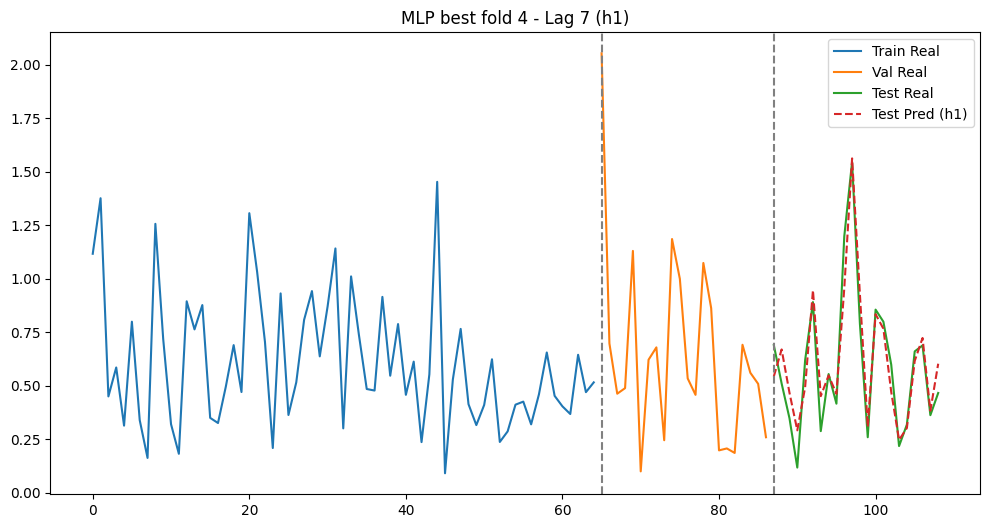

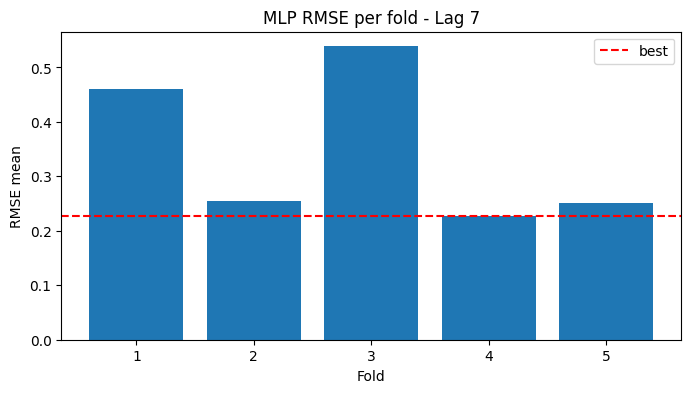

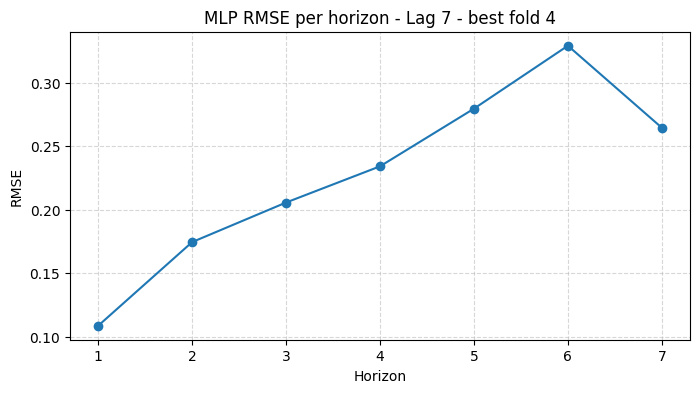

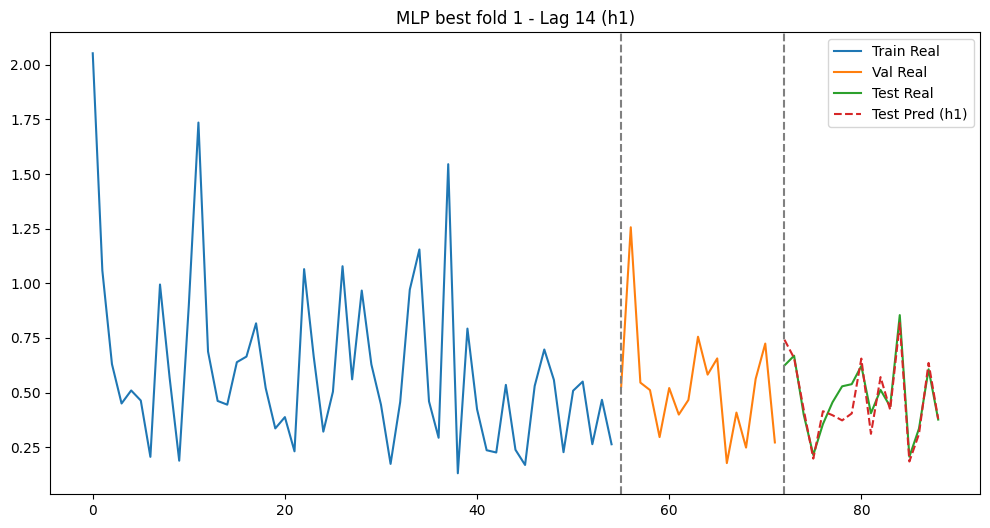

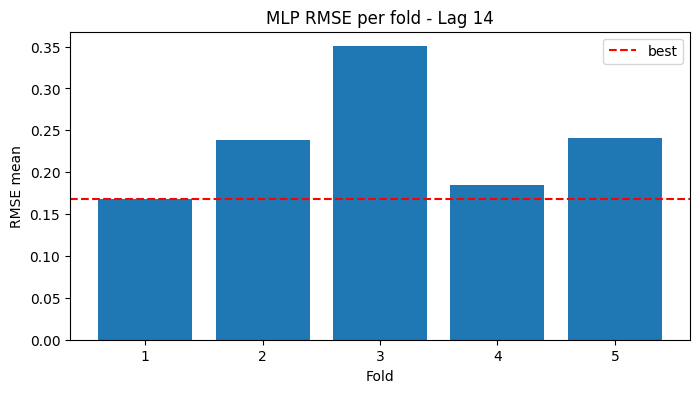

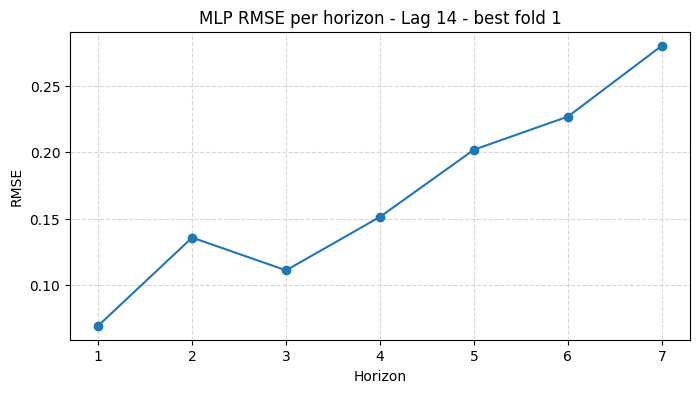

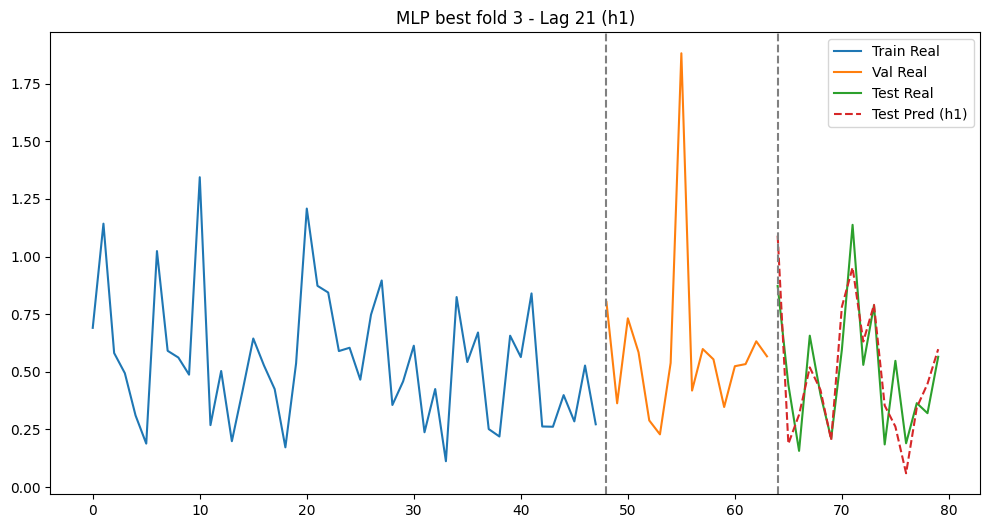

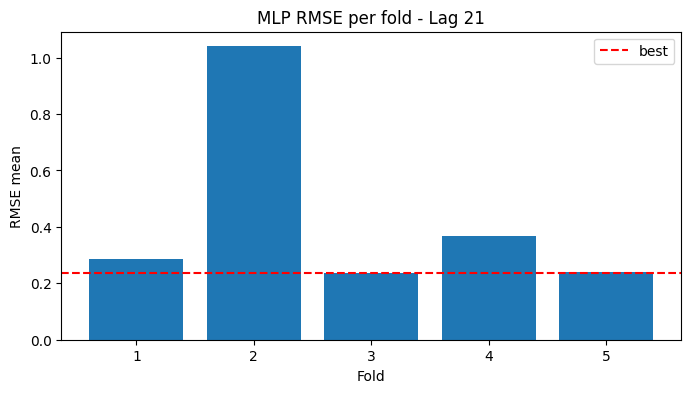

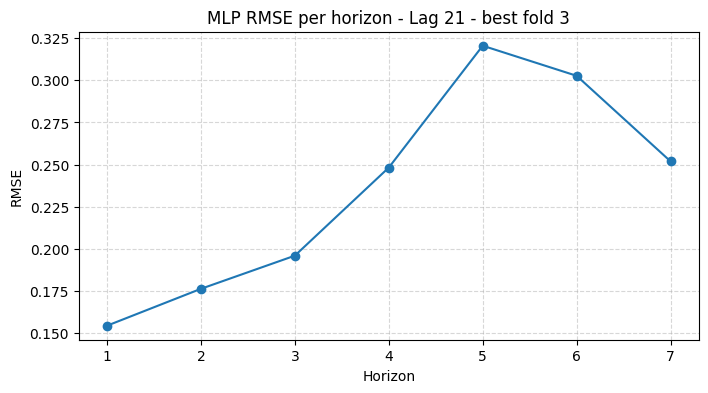

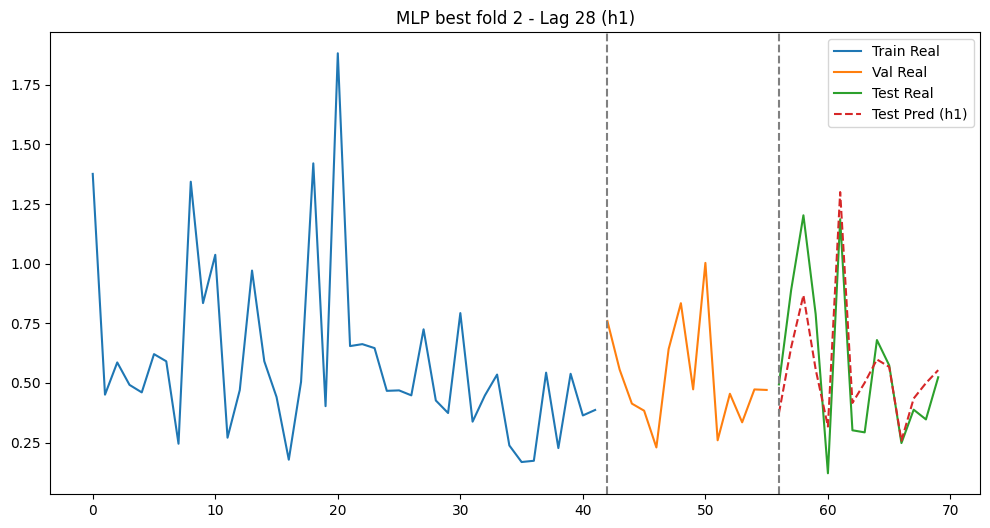

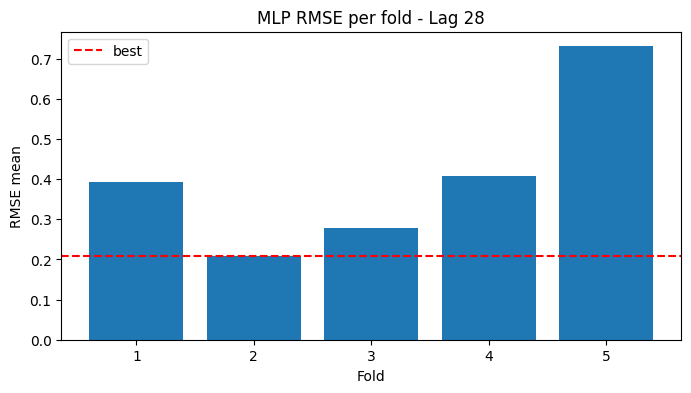

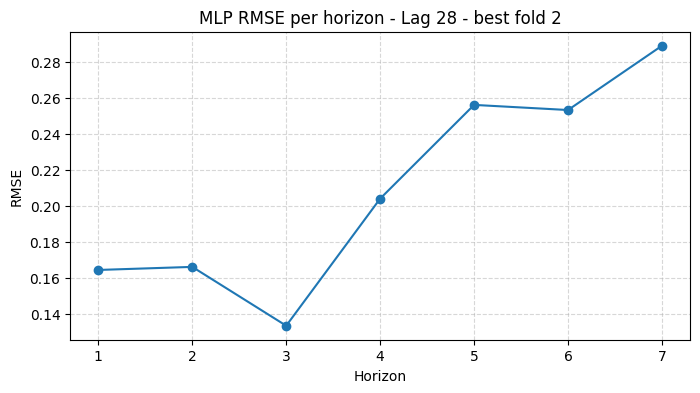

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


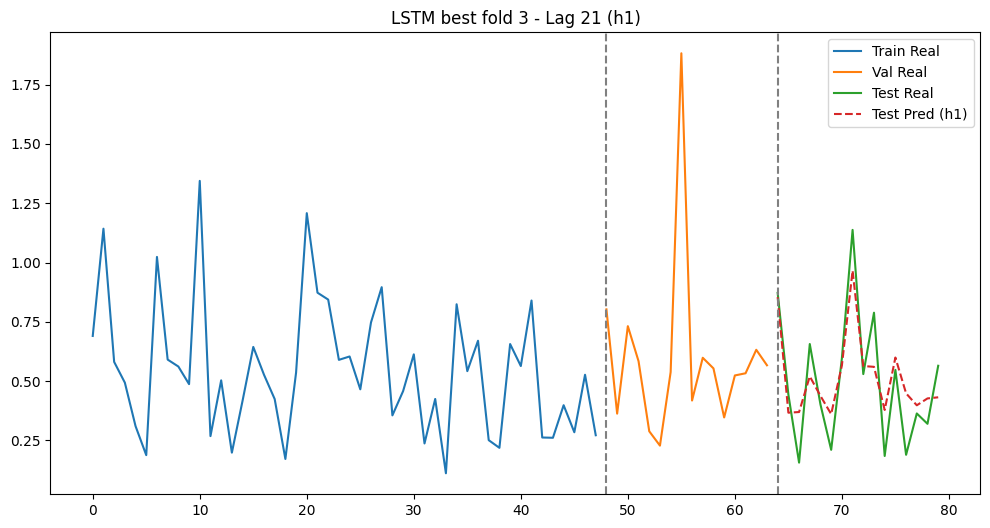

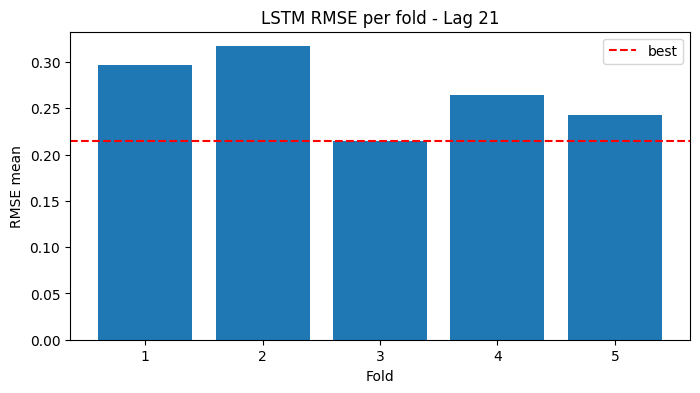

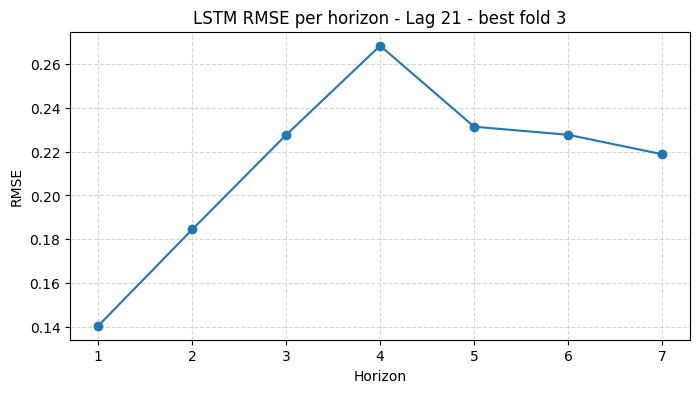

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


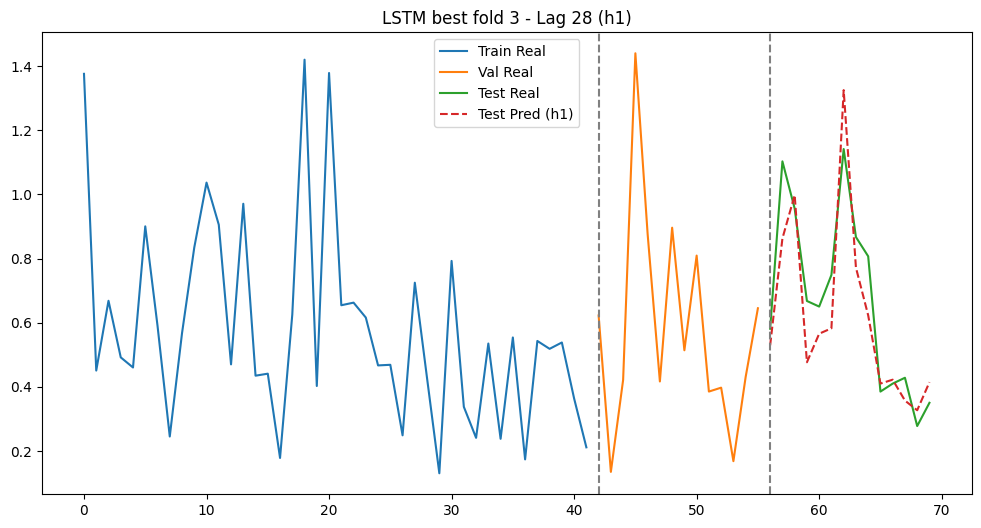

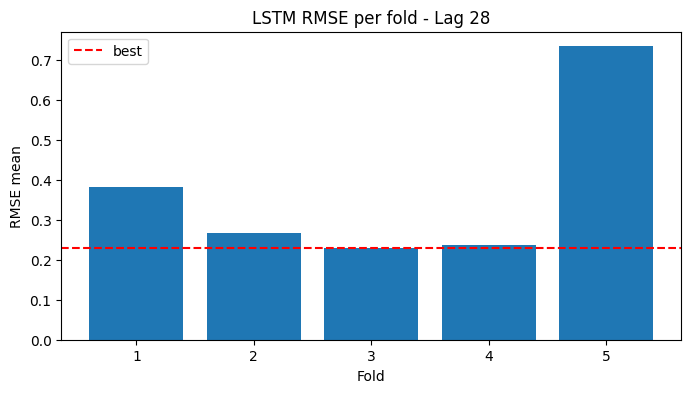

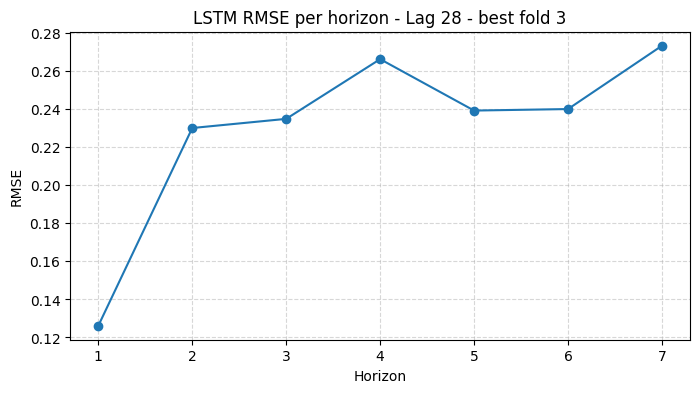


Done. All folds re-trained with provided hyperparams, metrics saved, and best-fold plots generated.


In [20]:
# Autocontained: retrain only using provided best hyperparams, collect metrics, produce plots & CSVs.
# Requirements: numpy, pandas, sklearn, tensorflow (keras), matplotlib, tsxv split function available.

import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ML / preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import Counter

# Keras LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# plotting
import matplotlib.pyplot as plt

# timeseries split
from tsxv.splitTrainValTest import split_train_val_test_groupKFold

# ---------------------------
# Utils
# ---------------------------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12))) * 100.0

def choose_scaler(kind):
    return StandardScaler() if kind == "standard" else MinMaxScaler(feature_range=(-1,1))

def rmse_per_horiz(y_true, y_pred):
    return np.array([np.sqrt(mean_squared_error(y_true[:,h], y_pred[:,h])) for h in range(y_true.shape[1])])

def bds_test(residuals, max_dim=3, eps_factor=0.5, n_bootstrap=200, random_state=42):
    """Return DataFrame indexed by m with columns statistic and p_value. Handles short samples."""
    import numpy as _np
    import pandas as _pd
    _np.random.seed(random_state)
    n = len(residuals)
    if n < 10:
        return _pd.DataFrame([(2, _np.nan, _np.nan)], columns=['m','statistic','p_value']).set_index('m')
    eps = eps_factor * _np.std(residuals)

    def embed(data, m):
        return _np.array([data[i:i + m] for i in range(n - m + 1)])

    def correlation_integral(X, eps):
        N = len(X)
        if N == 0:
            return 0.0
        count = 0
        for i in range(N):
            count += _np.sum(_np.linalg.norm(X - X[i], axis=1) < eps)
        return count / (N * N)

    results = []
    for m in range(2, max_dim + 1):
        Xm = embed(residuals, m)
        X1 = embed(residuals, 1)
        Cm = correlation_integral(Xm, eps)
        C1 = correlation_integral(X1, eps)
        bds_stat = _np.sqrt(n) * (Cm - C1**m)

        boot_stats = []
        for _ in range(n_bootstrap):
            shuffled = _np.random.permutation(residuals)
            Xm_boot = embed(shuffled, m)
            Cmb = correlation_integral(Xm_boot, eps)
            C1b = correlation_integral(embed(shuffled, 1), eps)
            boot_stats.append(_np.sqrt(n) * (Cmb - C1b**m))
        boot_stats = _np.array(boot_stats)
        p_value = ( _np.sum(_np.abs(boot_stats) >= _np.abs(bds_stat)) + 1 ) / (n_bootstrap + 1)
        results.append((m, bds_stat, p_value))

    return pd.DataFrame(results, columns=['m','statistic','p_value']).set_index('m')

# ---------------------------
# Load data (exactly as requested)
# ---------------------------
btc = pd.read_csv("btc_1d_data_2018_to_2025.csv")
btc = btc[["Open time", "Close"]].dropna().reset_index(drop=True)
btc = btc.rename(columns={"Open time": "Date"})
btc["Close"] = btc["Close"].astype(float)
btc["LogReturn"] = np.log(btc["Close"] / btc["Close"].shift(1))
window_size = 7
btc["Volatility"] = btc["LogReturn"].rolling(window=window_size).std() * np.sqrt(365)
btc = btc.sort_values("Date").reset_index(drop=True).dropna().reset_index(drop=True)
volatility_full = btc["Volatility"].values

# create directories
os.makedirs("notebooks/figs/mlp", exist_ok=True)
os.makedirs("notebooks/figs/lstm", exist_ok=True)
os.makedirs("results/mlp", exist_ok=True)
os.makedirs("results/lstm", exist_ok=True)

# ---------------------------
# Best hyperparams (you provided these earlier)
# ---------------------------
best_cfgs_mlp = {
    7:  {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 1e-05, 'learning_rate_init': 0.005, 'max_iter': 500, 'scaler': 'standard'},
    14: {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.01, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'},
    21: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'},
    28: {'hidden_layer_sizes': (200,), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.001, 'max_iter': 500, 'scaler': 'standard'},
}

best_cfgs_lstm = {
    21: {'units': 32, 'dropout': 0.2, 'lr': 0.0005, 'batch_size': 32, 'epochs': 50, 'n_layers': 1},
    28: {'units': 64, 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32, 'epochs': 50, 'n_layers': 1},
}

# ---------------------------
# Functions to build & fit final models (train on train+val)
# ---------------------------
def build_and_fit_mlp(X_train, y_train, cfg):
    scaler_x = choose_scaler(cfg.get("scaler","standard"))
    scaler_y = choose_scaler(cfg.get("scaler","standard"))
    Xs = scaler_x.fit_transform(X_train)
    ys = scaler_y.fit_transform(y_train)
    model = MLPRegressor(hidden_layer_sizes=cfg["hidden_layer_sizes"],
                         activation=cfg["activation"],
                         alpha=cfg["alpha"],
                         learning_rate_init=cfg["learning_rate_init"],
                         max_iter=cfg["max_iter"],
                         random_state=42)
    model.fit(Xs, ys)
    return model, scaler_x, scaler_y

def build_and_fit_lstm(X_train, y_train, cfg):
    # scaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    Xs = scaler_x.fit_transform(X_train)
    ys = scaler_y.fit_transform(y_train)
    # reshape for LSTM
    Xs_r = Xs.reshape((Xs.shape[0], Xs.shape[1], 1))
    # build model
    tf.random.set_seed(42)
    model = Sequential()
    if cfg.get("n_layers",1) == 1:
        model.add(LSTM(cfg["units"], input_shape=(Xs_r.shape[1], 1), return_sequences=False))
        if cfg["dropout"] > 0:
            model.add(Dropout(cfg["dropout"]))
    else:
        model.add(LSTM(cfg["units"], input_shape=(Xs_r.shape[1], 1), return_sequences=True))
        if cfg["dropout"] > 0:
            model.add(Dropout(cfg["dropout"]))
        model.add(LSTM(cfg["units"], return_sequences=False))
        if cfg["dropout"] > 0:
            model.add(Dropout(cfg["dropout"]))
    model.add(Dense(ys.shape[1]))
    opt = Adam(learning_rate=cfg["lr"])
    model.compile(loss="mse", optimizer=opt)
    model.fit(Xs_r, ys, epochs=cfg["epochs"], batch_size=cfg["batch_size"], verbose=0)
    return model, scaler_x, scaler_y

# ---------------------------
# Run retrain-only pipeline: MLP (lags 7,14,21,28), LSTM (21,28)
# For each fold: retrain on train+val with best_cfg, evaluate on test, store final_model & scalers for plotting
# ---------------------------
n_steps_out = 7
n_steps_jump = 50

folds_stats_dict = {"mlp": {}, "lstm": {}}
summary_rows = {"mlp": [], "lstm": []}

# Helper to summarize per-fold->summary
def summarize_folds(folds_stats):
    mae_arr = np.array([f["mae_mean"] for f in folds_stats])
    mse_arr = np.array([f["mse_mean"] for f in folds_stats])
    rmse_arr= np.array([f["rmse_mean"] for f in folds_stats])
    mape_arr= np.array([f["mape_mean"] for f in folds_stats])
    bds_arr = np.array([f.get("bds_pval_h1", np.nan) for f in folds_stats])
    return {
        "MAE_mean": float(np.mean(mae_arr)), "MAE_std": float(np.std(mae_arr)),
        "MSE_mean": float(np.mean(mse_arr)), "MSE_std": float(np.std(mse_arr)),
        "RMSE_mean": float(np.mean(rmse_arr)), "RMSE_std": float(np.std(rmse_arr)),
        "MAPE_mean": float(np.mean(mape_arr)), "MAPE_std": float(np.std(mape_arr)),
        "BDS_mean": float(np.nanmean(bds_arr)), "BDS_std": float(np.nanstd(bds_arr))
    }

# --- MLP ---
for lag, cfg in best_cfgs_mlp.items():
    print(f"\n>>> MLP: retraining & evaluating lag={lag}")
    Xs, ys, Xcvs, ycvs, Xtests, ytests = split_train_val_test_groupKFold(volatility_full, lag, n_steps_out, n_steps_jump)
    folds_stats = []
    for fi in range(len(Xs)):
        Xtr, ytr = Xs[fi], ys[fi]
        Xval, yval = Xcvs[fi], ycvs[fi]
        Xte, yte = Xtests[fi], ytests[fi]

        # retrain on train+val
        Xtrain_full = np.vstack([Xtr, Xval])
        ytrain_full = np.vstack([ytr, yval])
        final_model, scaler_x, scaler_y = build_and_fit_mlp(Xtrain_full, ytrain_full, cfg)

        # predict on test
        Xte_s = scaler_x.transform(Xte)
        yhat = scaler_y.inverse_transform(final_model.predict(Xte_s))
        # metrics per horizon
        per_h = []
        for h in range(n_steps_out):
            mae_h = mean_absolute_error(yte[:,h], yhat[:,h])
            mse_h = mean_squared_error(yte[:,h], yhat[:,h])
            rmse_h = np.sqrt(mse_h)
            mape_h = mape(yte[:,h], yhat[:,h])
            per_h.append((mae_h, mse_h, rmse_h, mape_h))

        mae_mean = np.mean([p[0] for p in per_h])
        mse_mean = np.mean([p[1] for p in per_h])
        rmse_mean= np.mean([p[2] for p in per_h])
        mape_mean= np.mean([p[3] for p in per_h])

        # bds on residuals horizon1
        resid_h1 = yte[:,0] - yhat[:,0]
        bds_df = bds_test(resid_h1, n_bootstrap=200)
        try:
            bds_pval = float(bds_df.loc[2, "p_value"])
        except Exception:
            bds_pval = np.nan

        folds_stats.append({
            "fold": fi+1,
            "best_cfg": cfg,
            "final_model": final_model,
            "scaler_x": scaler_x,
            "scaler_y": scaler_y,
            "per_h_metrics": per_h,
            "mae_mean": float(mae_mean),
            "mse_mean": float(mse_mean),
            "rmse_mean": float(rmse_mean),
            "mape_mean": float(mape_mean),
            "bds_pval_h1": bds_pval
        })
        print(f"  fold {fi+1}: RMSE={rmse_mean:.4f}, MAPE={mape_mean:.2f} (saved model in memory)")

    folds_stats_dict["mlp"][lag] = folds_stats
    summary = summarize_folds(folds_stats)
    summary["Lag"] = lag
    summary["Best_cfg_mode"] = str(cfg)
    summary_rows["mlp"].append(summary)
    # save per-lag CSV
    df_f = pd.DataFrame([{k:v for k,v in f.items() if k not in ('final_model','scaler_x','scaler_y')} for f in folds_stats])
    df_f.to_csv(f"results/mlp/folds_metrics_lag{lag}.csv", index=False)
    print(f"[saved] results/mlp/folds_metrics_lag{lag}.csv")

# --- LSTM ---
for lag, cfg in best_cfgs_lstm.items():
    print(f"\n>>> LSTM: retraining & evaluating lag={lag}")
    Xs, ys, Xcvs, ycvs, Xtests, ytests = split_train_val_test_groupKFold(volatility_full, lag, n_steps_out, n_steps_jump)
    folds_stats = []
    for fi in range(len(Xs)):
        Xtr, ytr = Xs[fi], ys[fi]
        Xval, yval = Xcvs[fi], ycvs[fi]
        Xte, yte = Xtests[fi], ytests[fi]

        # retrain on train+val
        Xtrain_full = np.vstack([Xtr, Xval])
        ytrain_full = np.vstack([ytr, yval])
        final_model, scaler_x, scaler_y = build_and_fit_lstm(Xtrain_full, ytrain_full, cfg)

        # predict on test (reshape)
        Xte_s = scaler_x.transform(Xte).reshape((Xte.shape[0], Xte.shape[1], 1))
        yhat = scaler_y.inverse_transform(final_model.predict(Xte_s))

        # per-h metrics
        per_h = []
        for h in range(n_steps_out):
            mae_h = mean_absolute_error(yte[:,h], yhat[:,h])
            mse_h = mean_squared_error(yte[:,h], yhat[:,h])
            rmse_h = np.sqrt(mse_h)
            mape_h = mape(yte[:,h], yhat[:,h])
            per_h.append((mae_h, mse_h, rmse_h, mape_h))

        mae_mean = np.mean([p[0] for p in per_h])
        mse_mean = np.mean([p[1] for p in per_h])
        rmse_mean= np.mean([p[2] for p in per_h])
        mape_mean= np.mean([p[3] for p in per_h])

        resid_h1 = yte[:,0] - yhat[:,0]
        bds_df = bds_test(resid_h1, n_bootstrap=200)
        try:
            bds_pval = float(bds_df.loc[2, "p_value"])
        except Exception:
            bds_pval = np.nan

        folds_stats.append({
            "fold": fi+1,
            "best_cfg": cfg,
            "final_model": final_model,
            "scaler_x": scaler_x,
            "scaler_y": scaler_y,
            "per_h_metrics": per_h,
            "mae_mean": float(mae_mean),
            "mse_mean": float(mse_mean),
            "rmse_mean": float(rmse_mean),
            "mape_mean": float(mape_mean),
            "bds_pval_h1": bds_pval
        })
        print(f"  fold {fi+1}: RMSE={rmse_mean:.4f}, MAPE={mape_mean:.2f} (saved model in memory)")

    folds_stats_dict["lstm"][lag] = folds_stats
    summary = summarize_folds(folds_stats)
    summary["Lag"] = lag
    summary["Best_cfg_mode"] = str(cfg)
    summary_rows["lstm"].append(summary)
    df_f = pd.DataFrame([{k:v for k,v in f.items() if k not in ('final_model','scaler_x','scaler_y')} for f in folds_stats])
    df_f.to_csv(f"results/lstm/folds_metrics_lag{lag}.csv", index=False)
    print(f"[saved] results/lstm/folds_metrics_lag{lag}.csv")

# ---------------------------
# Save summary CSVs
# ---------------------------
pd.DataFrame(summary_rows["mlp"]).to_csv("results/mlp/summary_metrics.csv", index=False)
pd.DataFrame(summary_rows["lstm"]).to_csv("results/lstm/summary_metrics.csv", index=False)
print("\n[Saved summary CSVs] results/mlp/summary_metrics.csv, results/lstm/summary_metrics.csv")

# ---------------------------
# Visualization: for each model+lag, plot best fold (by rmse_mean)
# ---------------------------
def plot_best_fold_for_model(model_key, lag):
    folds_stats = folds_stats_dict[model_key][lag]
    # pick best fold (lowest rmse_mean)
    rmse_arr = np.array([f["rmse_mean"] for f in folds_stats])
    best_idx = int(np.argmin(rmse_arr))
    entry = folds_stats[best_idx]

    # recover data splits for this lag
    Xs, ys, Xcvs, ycvs, Xtests, ytests = split_train_val_test_groupKFold(volatility_full, lag, n_steps_out, n_steps_jump)
    Xtr, ytr = Xs[best_idx], ys[best_idx]
    Xval, yval = Xcvs[best_idx], ycvs[best_idx]
    Xte, yte = Xtests[best_idx], ytests[best_idx]

    # model + scalers
    model_obj = entry["final_model"]
    scaler_x = entry["scaler_x"]
    scaler_y = entry["scaler_y"]

    # predict
    if model_key == "lstm":
        Xte_s = scaler_x.transform(Xte).reshape((Xte.shape[0], Xte.shape[1], 1))
        yhat = scaler_y.inverse_transform(model_obj.predict(Xte_s))
    else:
        Xte_s = scaler_x.transform(Xte)
        yhat = scaler_y.inverse_transform(model_obj.predict(Xte_s))

    # 1) time series (h1)
    plt.figure(figsize=(12,6))
    plt.plot(ytr[:,0], label="Train Real")
    plt.plot(range(len(ytr), len(ytr)+len(yval)), yval[:,0], label="Val Real")
    plt.plot(range(len(ytr)+len(yval), len(ytr)+len(yval)+len(yte)), yte[:,0], label="Test Real")
    plt.plot(range(len(ytr)+len(yval), len(ytr)+len(yval)+len(yte)), yhat[:,0], label="Test Pred (h1)", linestyle="--")
    plt.axvline(len(ytr), color="gray", linestyle="--")
    plt.axvline(len(ytr)+len(yval), color="gray", linestyle="--")
    plt.legend()
    plt.title(f"{model_key.upper()} best fold {best_idx+1} - Lag {lag} (h1)")
    plt.savefig(f"notebooks/figs/{model_key}/{model_key}_series_lag{lag}_bestfold{best_idx+1}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 2) RMSE per fold bars
    plt.figure(figsize=(8,4))
    plt.bar(range(1, len(rmse_arr)+1), rmse_arr)
    plt.axhline(rmse_arr[best_idx], color="red", linestyle="--", label="best")
    plt.xlabel("Fold")
    plt.ylabel("RMSE mean")
    plt.title(f"{model_key.upper()} RMSE per fold - Lag {lag}")
    plt.legend()
    plt.savefig(f"notebooks/figs/{model_key}/{model_key}_rmse_per_fold_lag{lag}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 3) RMSE per horizon for that best fold
    rmse_h = rmse_per_horiz(yte, yhat)
    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(rmse_h)+1), rmse_h, marker="o")
    plt.xlabel("Horizon")
    plt.ylabel("RMSE")
    plt.title(f"{model_key.upper()} RMSE per horizon - Lag {lag} - best fold {best_idx+1}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.savefig(f"notebooks/figs/{model_key}/{model_key}_rmse_per_horizon_lag{lag}_bestfold{best_idx+1}.png", dpi=300, bbox_inches="tight")
    plt.show()

# plot all
for lag in best_cfgs_mlp.keys():
    plot_best_fold_for_model("mlp", lag)
for lag in best_cfgs_lstm.keys():
    plot_best_fold_for_model("lstm", lag)

print("\nDone. All folds re-trained with provided hyperparams, metrics saved, and best-fold plots generated.")
